# Proyecto de Machine Learning: Predicción y Clasificación de Problemas del Sueño en Personas

Este proyecto aplica técnicas de **Machine Learning** para analizar datos de salud y estilo de vida con el objetivo de:

1. **Predecir si una persona tiene problemas en la calidad de su sueño** (sueño saludable vs. sueño no saludable).
2. **Clasificar el tipo de trastorno del sueño**, en caso de que se detecte un problema con el sueño:
   - **Insomnio**
   - **Apnea del sueño**

### Modelos utilizados:
- **Random Forest**: Para detectar si tienes o no problema en la calidad del sueño.
- **XGBoost Classifier**: Para clasificar que tipo de trastorno padeces cuando se detecta probelmas con el sueño.

---

### Funcionalidades interactivas en Streamlit

La aplicación desarrollada con **Streamlit** ofrece al usuario una experiencia:

- **Predicción personalizada**: El usuario introduce sus datos y obtiene un diagnóstico automático sobre su calidad del sueño.
- **Recomendaciones geolocalizadas**: La aplicación permite consultar clínicas o centros especializados cercanos a su ciudad para realizar un estudio del sueño o trabajar en la mejora del sueño.
- **Envío automático por correo**: La información dada sobre una clinica o lo que el usuario pregunte, puede ser enviada por correo electrónico al usuario.

---

Este proyecto no solo busca ofrecer una herramienta de predicción, sino también una ayuda práctica para el usuario, orientándolo hacia mejorar su salud del sueño.

## Objetivos del Proyecto

El objetivo principal de este proyecto es desarrollar un sistema automatizado que pueda analizar información personal ofrecida de un usuario para:

-  **Detectar posibles trastornos del sueño**.
-  **Clasificar el tipo de trastorno cuando sea necesario**.
-  **Sugerir acciones o recursos útiles**, como centros especializados cercanos.
-  **Sea preciso**.
-  **Funcione con los datos que las personas pueden proveer fácilmente**

Este sistema puede ser útil como herramienta preventiva y de concienciación sobre la importancia del sueño en la salud general.

# Origen dataset
El dataset es descargado de la plataforma **kaggle.com**

## Primero necesitamos importar todas las herramientas necesarias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import os
sys.path.append(os.path.abspath('./src/utils'))

from toolbox_ML import *
from bootcampviztools import *

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SequentialFeatureSelector
from collections import Counter
from scipy.stats import mannwhitneyu

from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC 
from sklearn.linear_model import Lasso

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import ConfusionMatrixDisplay, classification_report

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

import joblib

## Cargamos el dataset y hacemos una descripción de los datos

In [2]:
df = pd.read_csv('./src/data/Sleep_Health_and_Lifestyle.csv', index_col = [0])

- **Person ID**: Indice por filas
- **Gender**: Genero de las personas 
- **Age**: Edad de las personas en años
- **Occupation**: A que se dedican las personas
- **Sleep Duration**: Cantidad de horas que duerme esa persona
- **Quality of Sleep**: Ratio del 1 al 10 de la calidad del sueño, según el criterio de la persona
- **Physical Activity Level**: Tiempo en minutos de actividad fisica al día
- **Stress Level**: Ratio del 1 al 10 del estrés, según el criterio de la persona
- **BMI Category**: Sería el índice de masa corporal pero en cuatro niveles (Normal, sobrepeso...)
- **Blood Pressure**: La medida de la presión arterial de la persona, indicada como presión sistólica sobre presión diastólica.
- **Heart Rate**: Latidos por minuto de la persona en resposo
- **Daily Steps**: Pasos diarios de la persona
- **Sleep Disorder**: (target) indica si tiene un problema con el sueño o no (NaN)

## Mostramos información básica del dataset

In [3]:
df.sample(5)

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
Person ID,,,,,,,,,,,,
263,Female,45,Teacher,6.6,7,45,4,Overweight,135/90,65,6000,NaN
136,Male,38,Lawyer,7.3,8,60,5,Normal,130/85,68,8000,NaN
301,Female,51,Engineer,8.5,9,30,3,Normal,125/80,65,5000,NaN
350,Female,57,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
309,Female,52,Accountant,6.6,7,45,7,Overweight,130/85,72,6000,Insomnia


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 374 entries, 1 to 374
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gender                   374 non-null    object 
 1   Age                      374 non-null    int64  
 2   Occupation               374 non-null    object 
 3   Sleep Duration           374 non-null    float64
 4   Quality of Sleep         374 non-null    int64  
 5   Physical Activity Level  374 non-null    int64  
 6   Stress Level             374 non-null    int64  
 7   BMI Category             374 non-null    object 
 8   Blood Pressure           374 non-null    object 
 9   Heart Rate               374 non-null    int64  
 10  Daily Steps              374 non-null    int64  
 11  Sleep Disorder           155 non-null    object 
dtypes: float64(1), int64(6), object(5)
memory usage: 38.0+ KB


## Los valores que faltan en 'Sleep Disorder' son los que indican que no sufre ningún trastorno del sueño

In [5]:
describe_df(df)

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
DATA_TYPE,object,int64,object,float64,int64,int64,int64,object,object,int64,int64,object
MISSINGS(%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58.56
UNIQUE_VALUES,2,31,11,27,6,16,6,4,25,19,20,3
CARDIN(%),0.53,8.29,2.94,7.22,1.6,4.28,1.6,1.07,6.68,5.08,5.35,0.8


In [6]:
tipifica_variables(df, 10, 0.20)

,variable,tipo_sugerido
0,Gender,Binaria
1,Age,Numérica discreta
2,Occupation,Numérica discreta
3,Sleep Duration,Numérica discreta
4,Quality of Sleep,Categórica
5,Physical Activity Level,Numérica discreta
6,Stress Level,Categórica
7,BMI Category,Categórica
8,Blood Pressure,Numérica discreta
9,Heart Rate,Numérica discreta


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,374.0,42.184492,8.673133,27.0,35.25,43.0,50.0,59.0
Sleep Duration,374.0,7.132086,0.795657,5.8,6.40,7.2,7.8,8.5
Quality of Sleep,374.0,7.312834,1.196956,4.0,6.00,7.0,8.0,9.0
Physical Activity Level,374.0,59.171123,20.830804,30.0,45.00,60.0,75.0,90.0
Stress Level,374.0,5.385027,1.774526,3.0,4.00,5.0,7.0,8.0
Heart Rate,374.0,70.165775,4.135676,65.0,68.00,70.0,72.0,86.0
Daily Steps,374.0,6816.844920,1617.915679,3000.0,5600.00,7000.0,8000.0,10000.0


In [8]:
df.Occupation.value_counts()

Occupation
Nurse                   73
Doctor                  71
Engineer                63
Lawyer                  47
Teacher                 40
Accountant              37
Salesperson             32
Scientist                4
Software Engineer        4
Sales Representative     2
Manager                  1
Name: count, dtype: int64

## Tenemos que tener en cuenta que 'Manager' 1, quizás nos da algún problema en el split, ya que 'Manager', estará en train o test, no en los dos

## Separamos las columnas que son categóricas

In [9]:
cat_features = ['Gender', 'Occupation', 'BMI Category']

# **Primera fase**

## Retocamos el target porque en la primera fase lo usaremos para detectar si tienes problema con el sueño o no

In [10]:
df['Sleep Disorder'] = df['Sleep Disorder'].fillna('NaN')

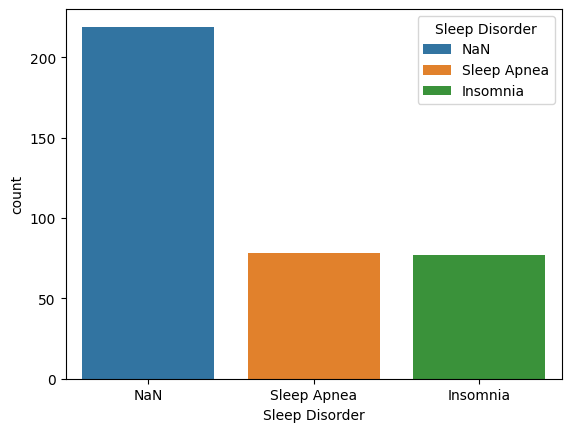

In [11]:
sns.countplot(df, x='Sleep Disorder', hue= 'Sleep Disorder', legend=True)
plt.show()

## Codificamos como 0 (NaN(buen sueño)), 1 (Sleep Apnea) + (Insomnia)

In [12]:
mapeo = {'NaN':0, 'Sleep Apnea':1, 'Insomnia':1}
df['Sleep Disorder'] = df['Sleep Disorder'].map(mapeo)

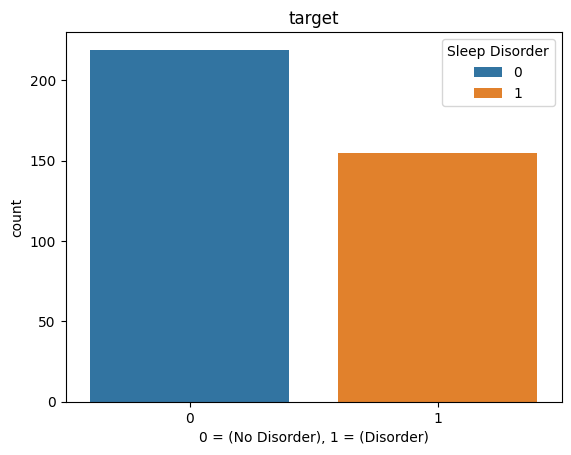

In [13]:
sns.countplot(df, x='Sleep Disorder', hue= 'Sleep Disorder', legend=True)
plt.xlabel('0 = (No Disorder), 1 = (Disorder)')
plt.title('target')
plt.show()

In [14]:
df['Sleep Disorder'].value_counts(True)

Sleep Disorder
0    0.585561
1    0.414439
Name: proportion, dtype: float64

## De esta forma tenemos un target binario, así podemos implementar diferentes métricas depende del proceso, en este caso será la métrica de **recall**, como lo más importante es no dejar pasar a positivos, por esta razón se usa el scoring de recall, muy usada en la sanidad

## Ahora hacemos el split de los datos

In [15]:
train_set, test_set = train_test_split(df, test_size = 0.2, random_state = 42)

In [16]:
print(train_set.shape)
print(test_set.shape)

(299, 12)
(75, 12)


In [17]:
train_set.reset_index(inplace=True)

## Vamos a hacer todas las transformaciones necesarias para dejar los datos listos para el modelo predictivo

In [18]:
train_set.drop(columns='Person ID', inplace=True) # esta columna no nos aporta valor
train_set.rename(columns = {'Sleep Disorder':'target'}, inplace=True) # cambio de nombre para un futuro mejor
# vamos a separar la columna de 'blood pressure' y vamos a calcular la presion del pulso
train_set[['systolic','diastolic']] = train_set['Blood Pressure'].str.extract(r'(\d+)/(\d+)', expand=True)
train_set.drop(columns='Blood Pressure', inplace=True)
train_set['systolic'] = train_set['systolic'].astype(int)
train_set['diastolic'] = train_set['diastolic'].astype(int)
# sacamos una nueva columna que es la de la presión del pulso
train_set['Pulse Pressure'] = train_set['systolic'] - train_set['diastolic']

In [19]:
train_set.sample(5)

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,target,systolic,diastolic,Pulse Pressure
145,Male,44,Salesperson,6.4,6,45,7,Overweight,72,6000,1,130,85,45
124,Male,39,Lawyer,7.2,8,60,5,Normal,68,8000,0,130,85,45
214,Male,31,Doctor,7.7,7,75,6,Normal,70,8000,0,120,80,40
234,Female,43,Teacher,6.7,7,45,4,Overweight,65,6000,1,135,90,45
153,Female,49,Nurse,6.2,6,90,8,Overweight,75,10000,1,140,95,45


## Sacamos las features que son numéricas y ver outliers

In [20]:
numericas_features = []
for x in train_set.columns:
    if x not in cat_features and x != 'target':
        numericas_features.append(x)

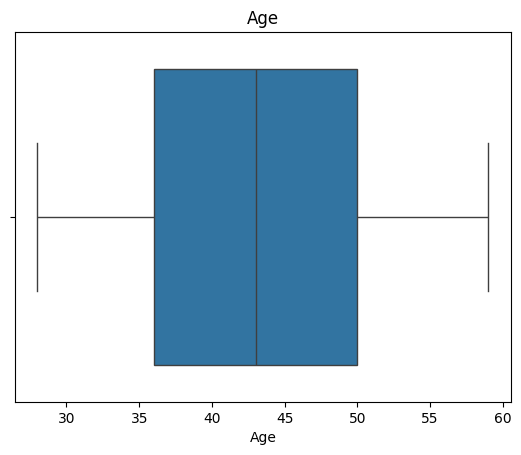

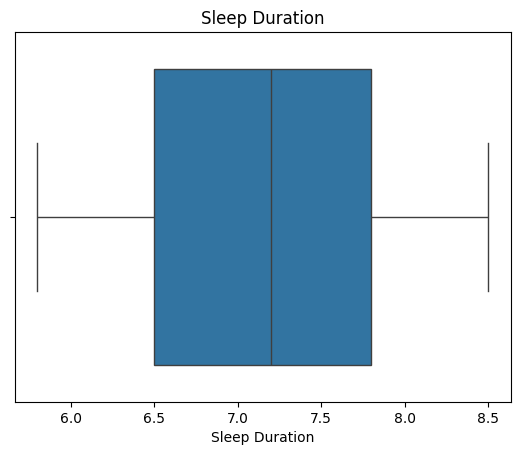

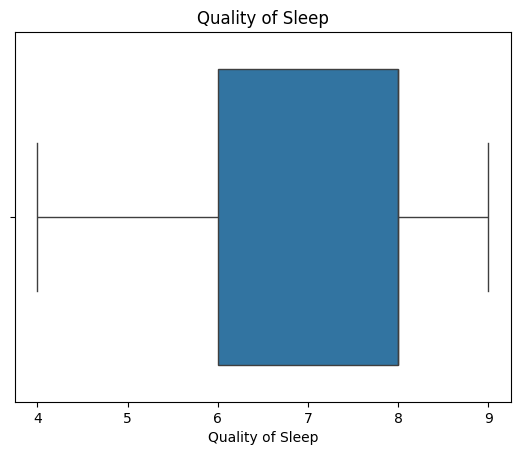

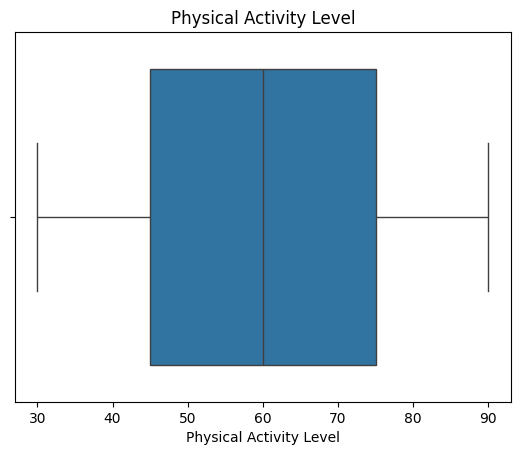

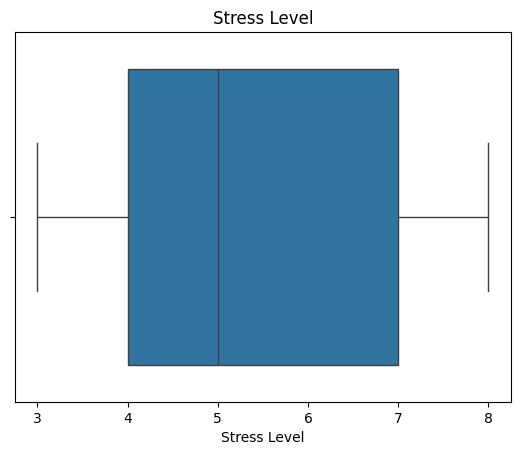

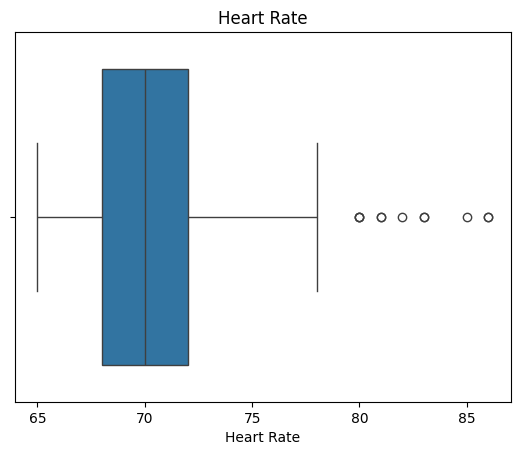

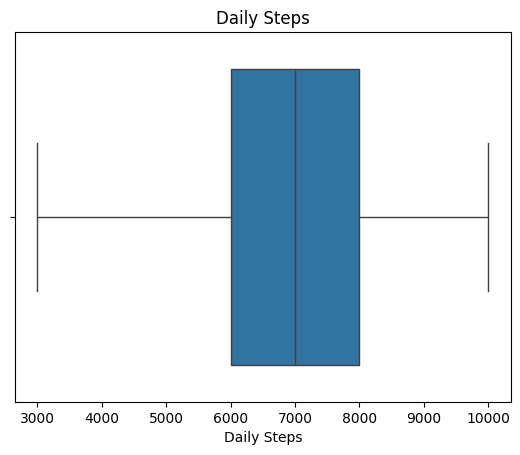

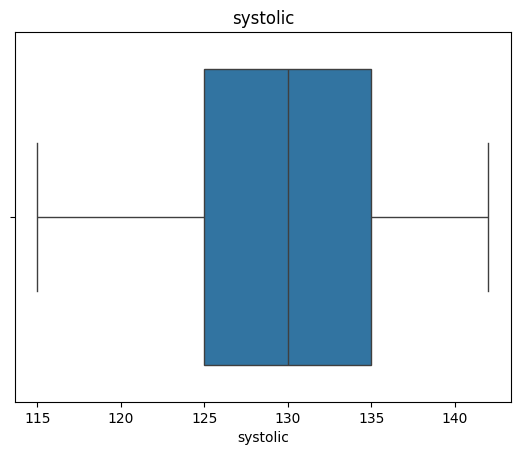

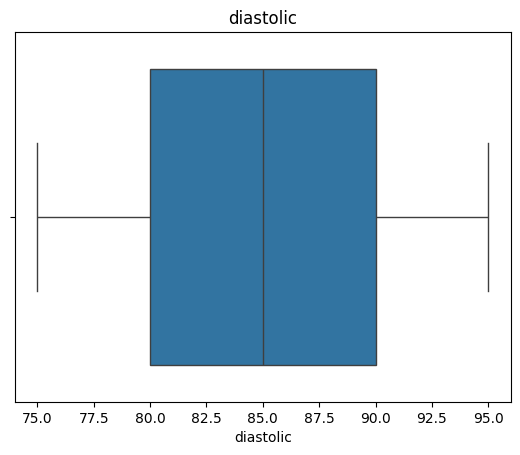

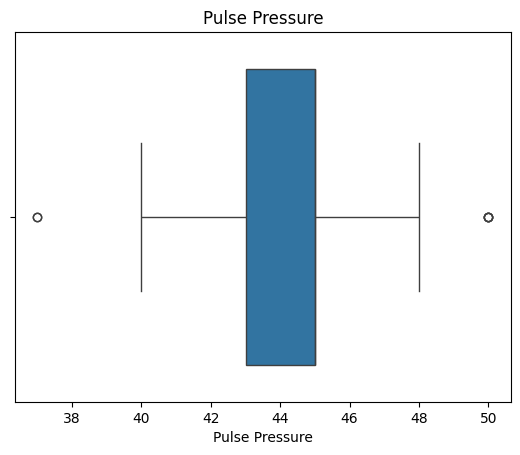

In [21]:
for x in numericas_features:
    plt.figure()
    sns.boxplot(x = train_set[x])
    plt.title(x)

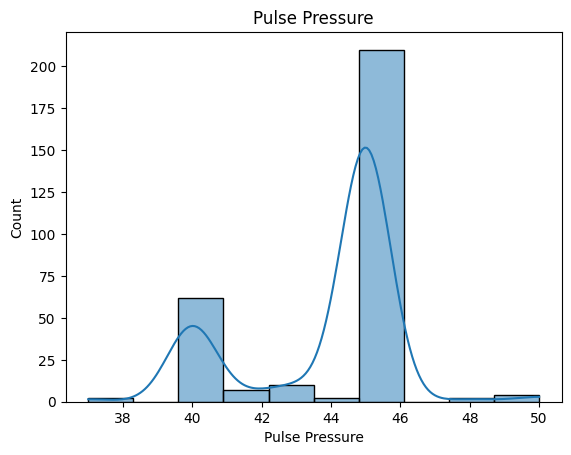

In [22]:
sns.histplot(train_set, x='Pulse Pressure', kde=True, bins=10)
plt.title('Pulse Pressure')
plt.show()

### Parecen haber outliers en la presión del pulso, pero no son outliers porque la presión del pulso está dentro de los normal

## El siguiente paso es ver las features comparadas con el target para ver su distribución con forma de histogramas y gráficos de barras

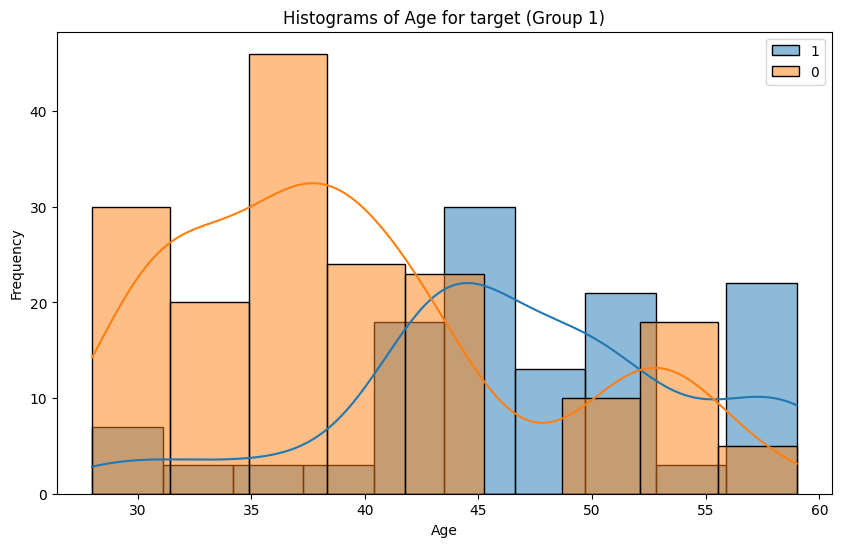

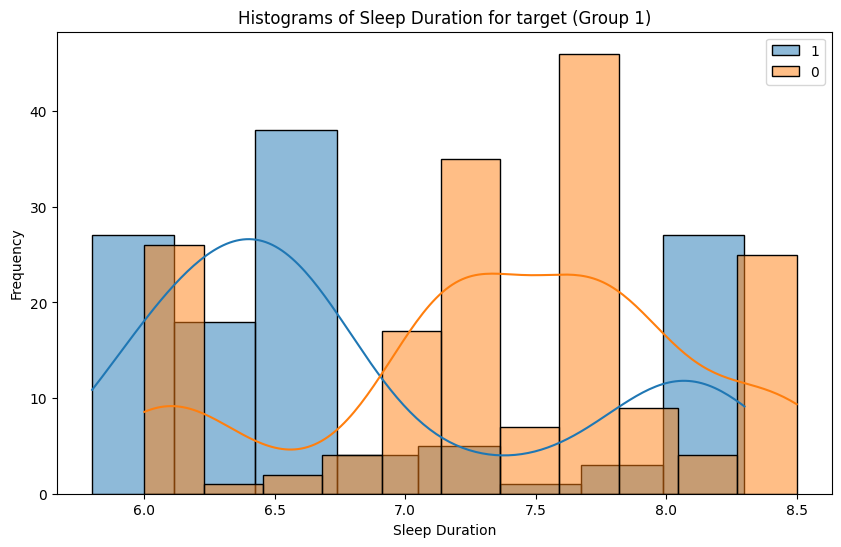

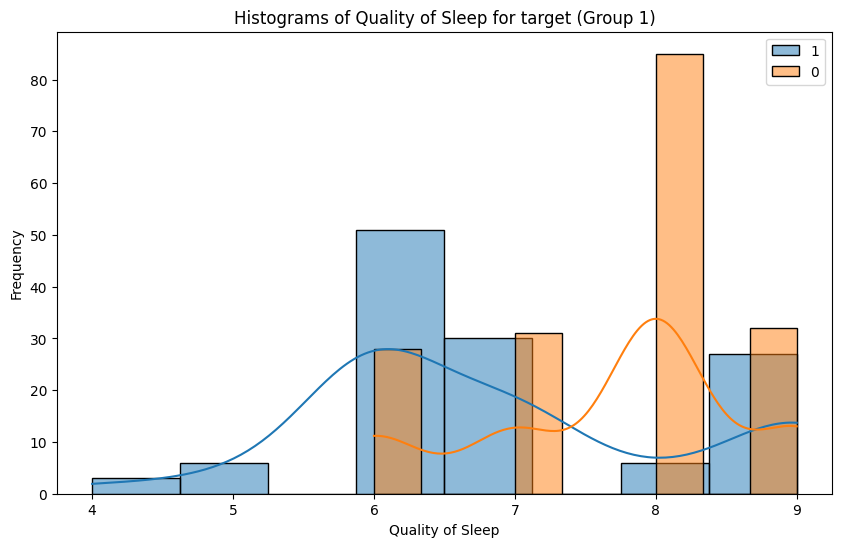

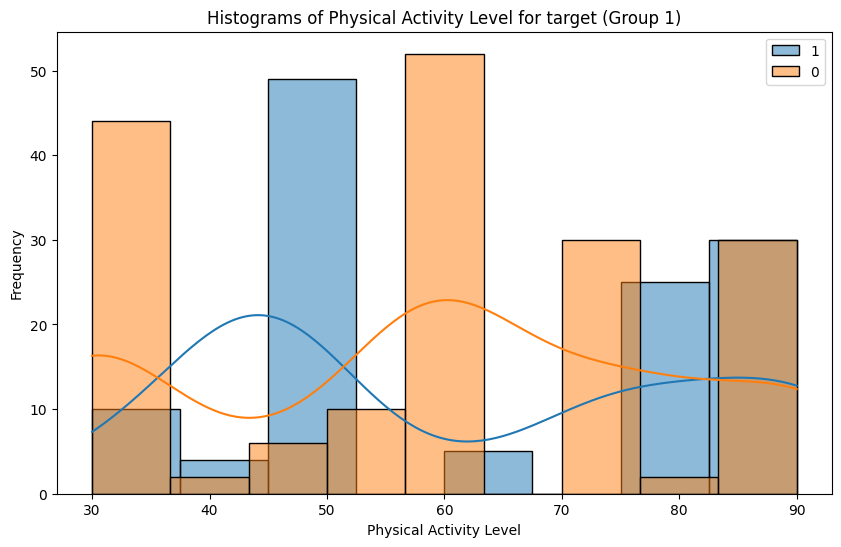

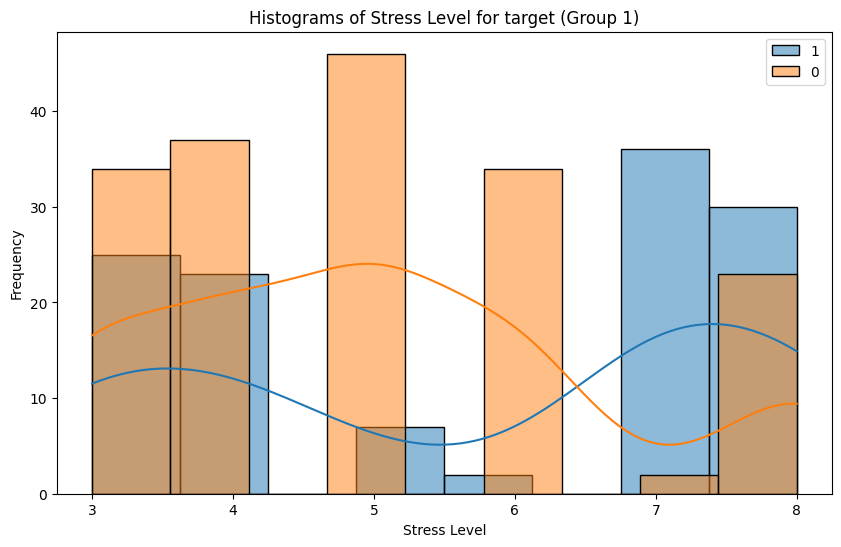

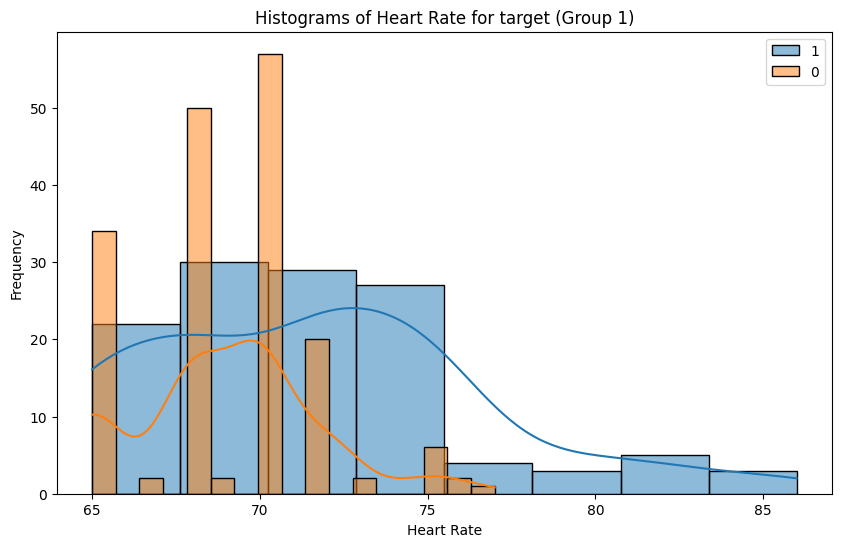

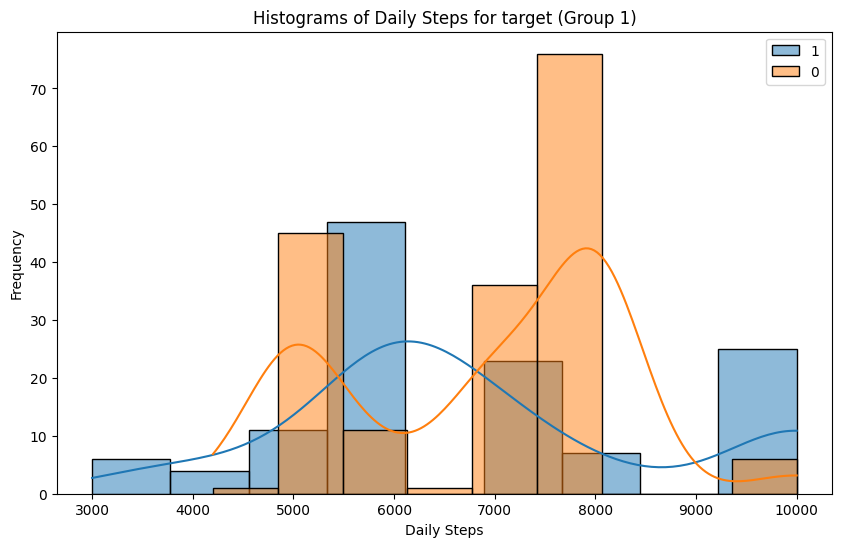

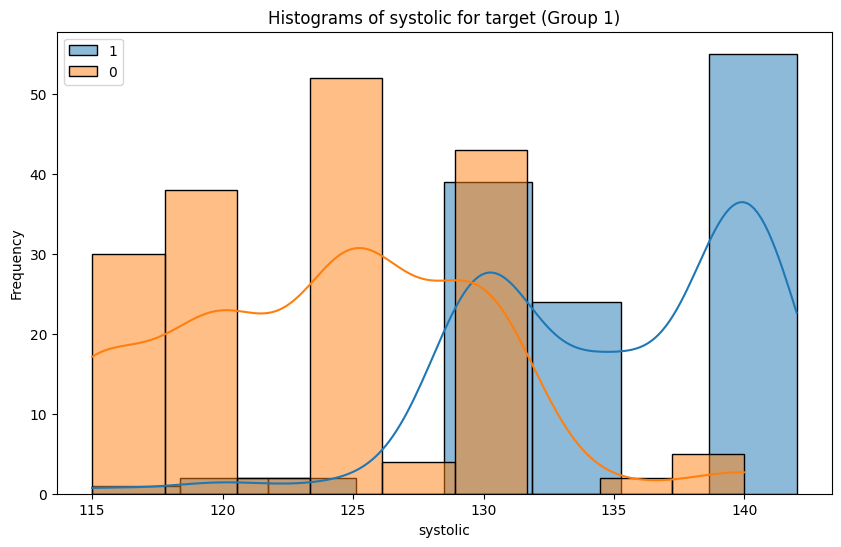

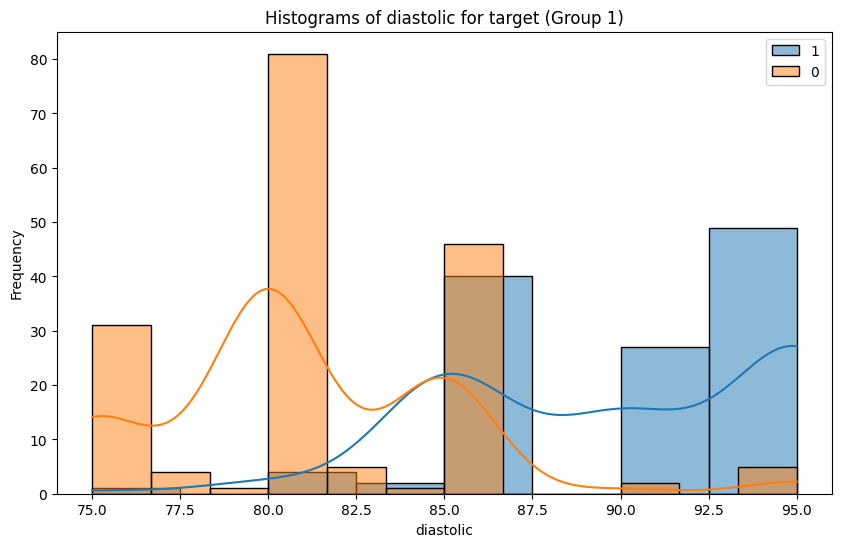

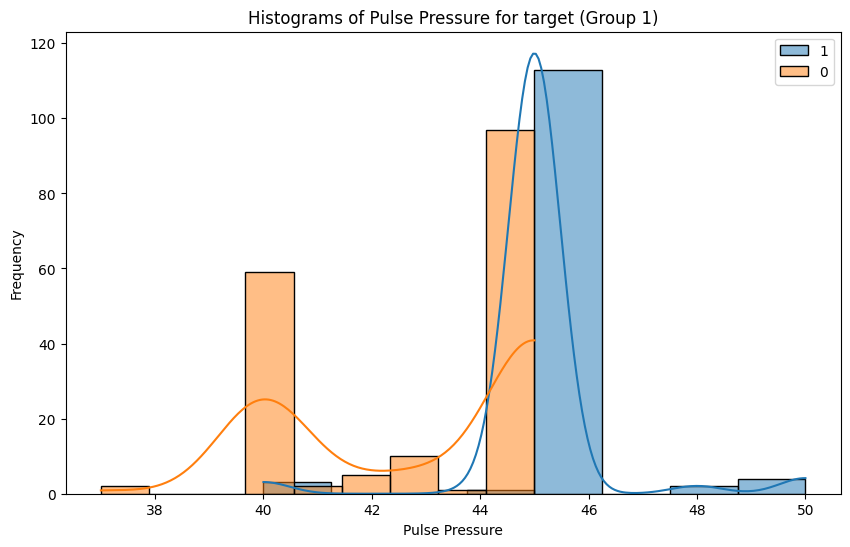

In [23]:
for x in numericas_features:
    plot_grouped_histograms(train_set, 'target', x, group_size=2)

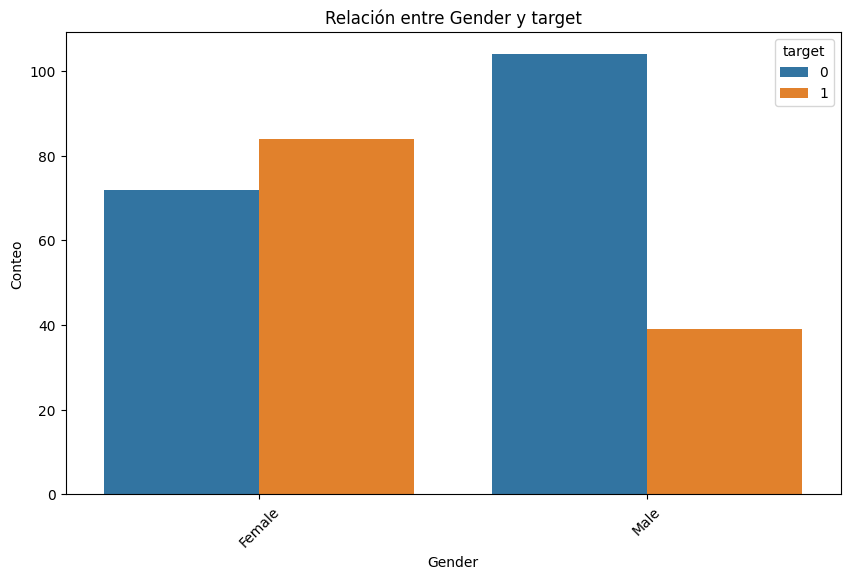

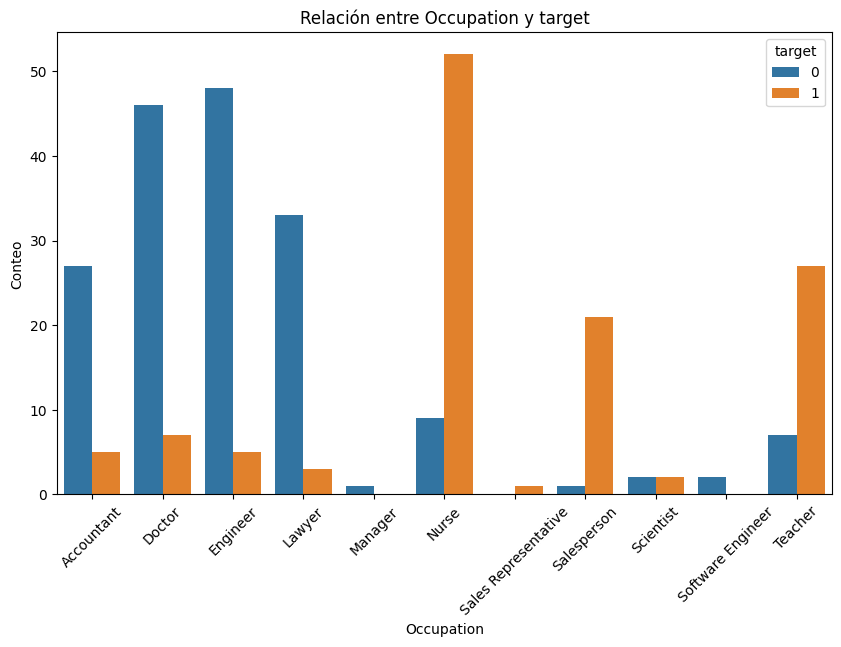

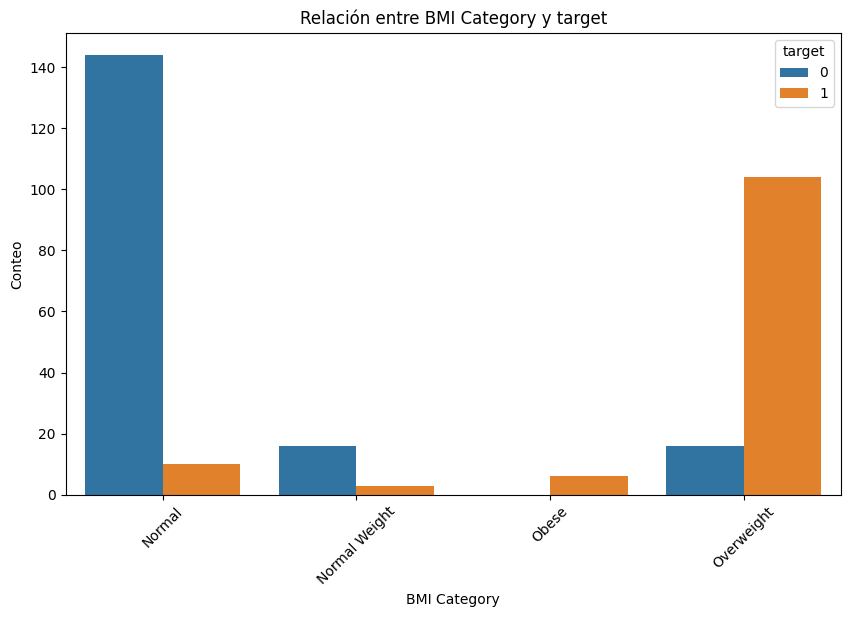

In [24]:
for x in cat_features:
    plot_categorical_relationship_fin(train_set, cat_col1=x, cat_col2='target', size_group=11)

## Se ve una buena relación entre las features contra el target, hay una diferencia entre los que no tienen problema del sueño y los que tienen problemas en el sueño.

## Vamos a codificar esas features categóricas

In [25]:
train_set['BMI Category'].value_counts()

BMI Category
Normal           154
Overweight       120
Normal Weight     19
Obese              6
Name: count, dtype: int64

In [26]:
train_set['Gender_code'] = train_set['Gender'].apply(lambda x: 0 if x == 'Male' else 1)
# vamos a unir 'normal' con 'normal weight' y 'overweight' con 'obese' porque indican lo mismo
train_set['BMI Category'] = train_set['BMI Category'].map({'Normal Weight': 'Normal','Normal':'Normal', 'Overweight':'Overweight', 'Obese': 'Overweight'})
train_set['BMI Category_code'] = train_set['BMI Category'].apply(lambda x: 0 if x == 'Normal' else 1)
dummies = pd.get_dummies(train_set['Occupation']).astype(int)
train_set = pd.concat([train_set, dummies], axis = 1)

In [27]:
pd.set_option('display.max_columns', None)

In [28]:
train_set.head(5)

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,target,systolic,diastolic,Pulse Pressure,Gender_code,BMI Category_code,Accountant,Doctor,Engineer,Lawyer,Manager,Nurse,Sales Representative,Salesperson,Scientist,Software Engineer,Teacher
0,Male,43,Salesperson,6.5,6,45,7,Overweight,72,6000,1,130,85,45,0,1,0,0,0,0,0,0,0,1,0,0,0
1,Male,33,Doctor,6.0,6,30,8,Normal,72,5000,0,125,80,45,0,0,0,1,0,0,0,0,0,0,0,0,0
2,Male,35,Software Engineer,7.5,8,60,5,Normal,70,8000,0,120,80,40,0,0,0,0,0,0,0,0,0,0,0,1,0
3,Female,59,Nurse,8.2,9,75,3,Overweight,68,7000,1,140,95,45,1,1,0,0,0,0,0,1,0,0,0,0,0
4,Female,29,Nurse,6.5,5,40,7,Normal,80,4000,1,132,87,45,1,0,0,0,0,0,0,1,0,0,0,0,0


In [29]:
pd.reset_option('display.max_columns', None)

In [30]:
# le cambiamos le tipo para los modelos que aceptan categóricas de tipo category
train_set['Gender'] = train_set['Gender'].astype('category')
train_set['Occupation'] = train_set['Occupation'].astype('category')
train_set['BMI Category'] = train_set['BMI Category'].astype("category")

In [31]:
categoricas_category = ['Gender', 'Occupation', 'BMI Category']

In [32]:
categoricas_int = ['Gender_code', 'Accountant','Doctor','Engineer','Lawyer','Manager','Nurse','Sales Representative',
               'Salesperson','Scientist','Software Engineer','Teacher', 'BMI Category_code']

In [33]:
numericas = ['Age','Sleep Duration','Quality of Sleep','Physical Activity Level','Stress Level', 
             'Heart Rate','Daily Steps', 'systolic', 'diastolic','Pulse Pressure']

In [34]:
target = 'target'

## Vamos a ver la comparación de las features con el target, otra forma de verlo con pairplot de seaborn

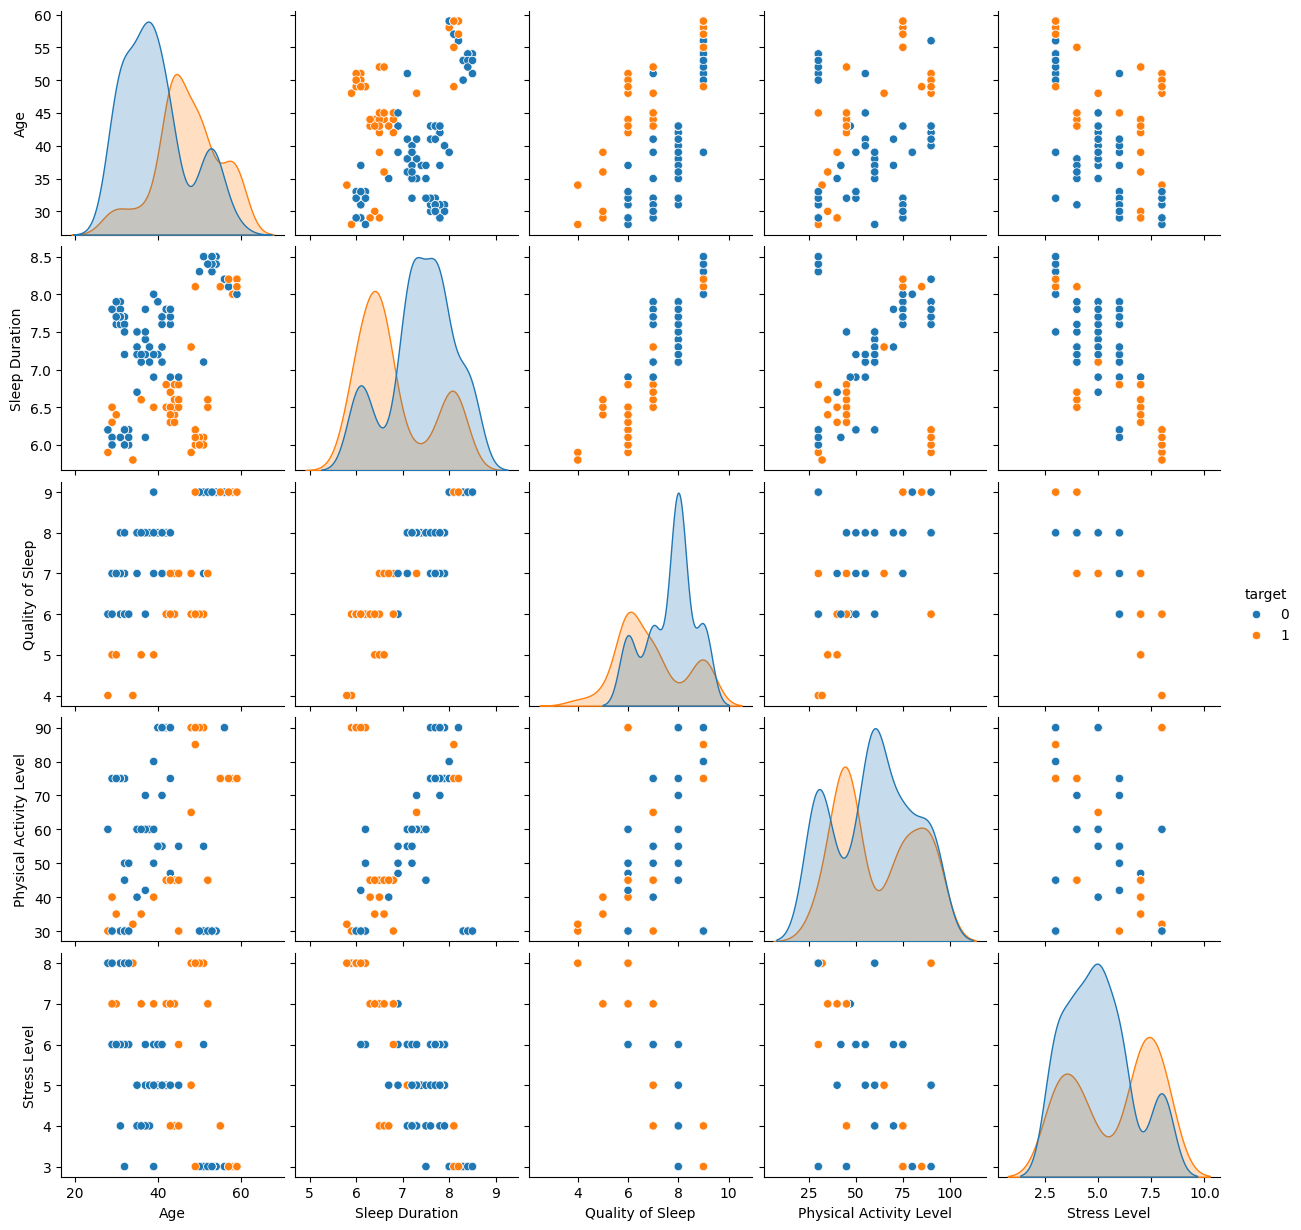

In [35]:
sns.pairplot(train_set[numericas[0:5] + [target]], hue = target);

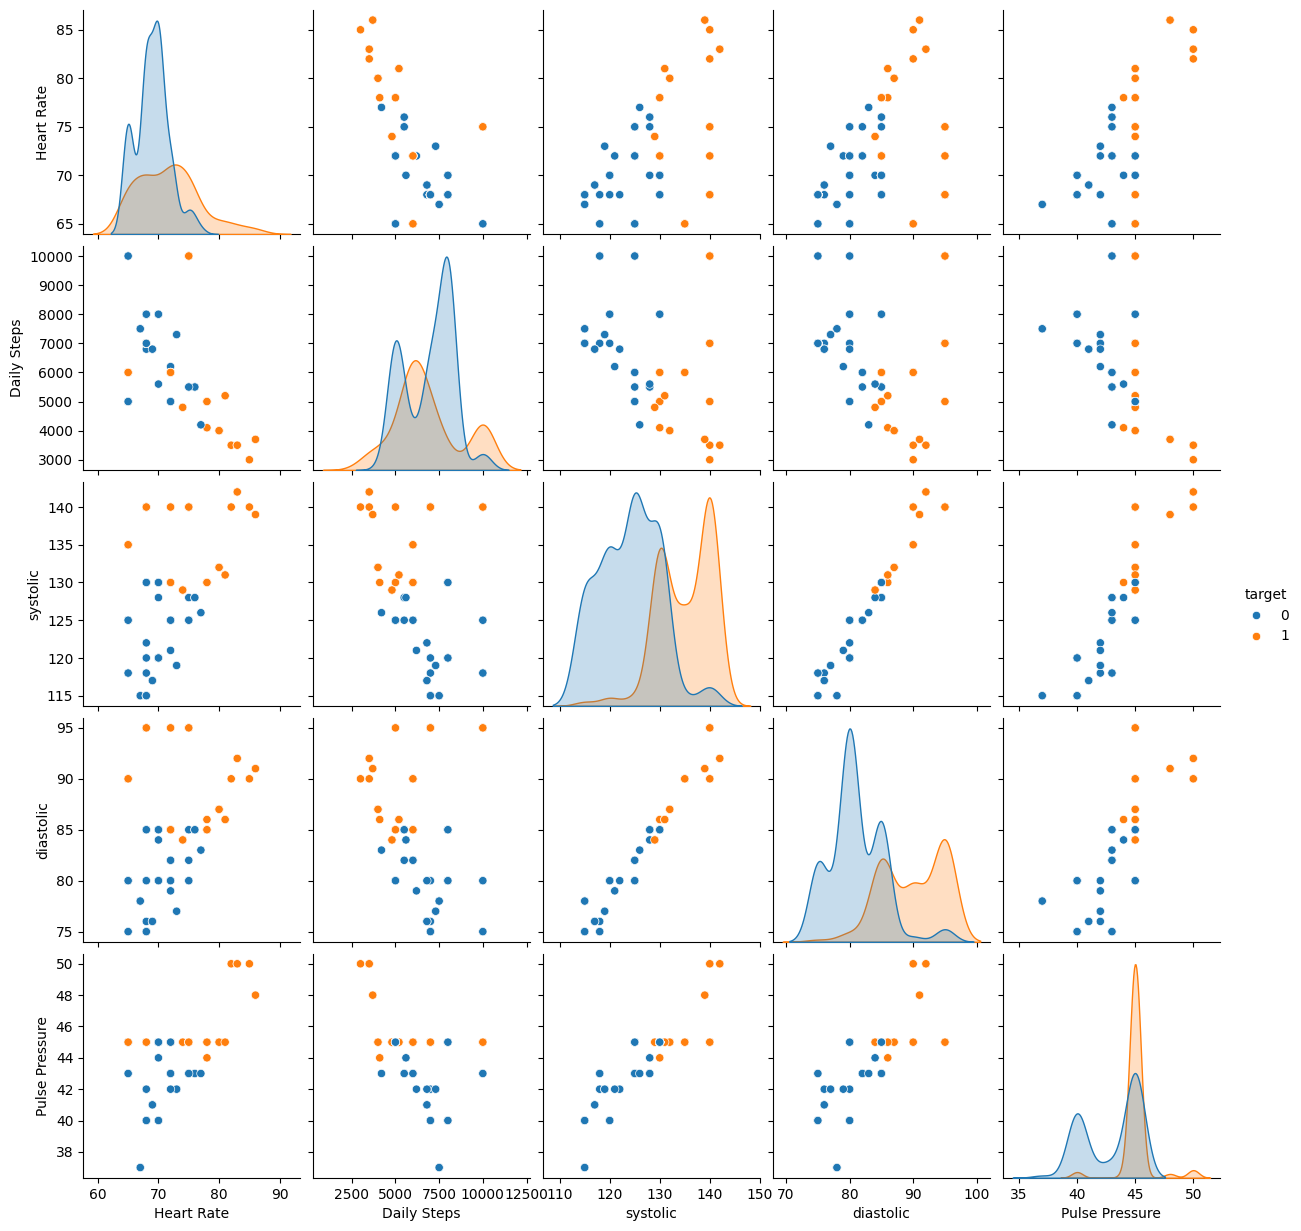

In [36]:
sns.pairplot(train_set[numericas[5:] + [target]], hue = target);

## Las features contra el target se diferencian bien, lo mismo que vimos en en análisis bivariante anterior

## Vamos a sacar un heatmap de seaborn para ver las correlaciones de las features numéricas

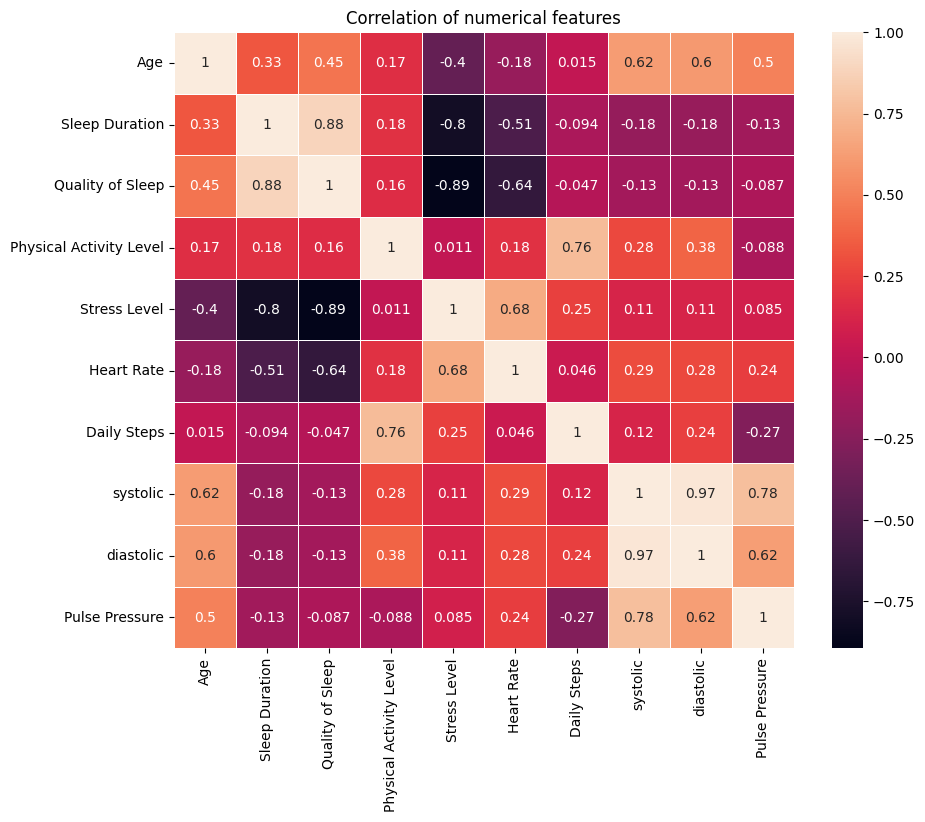

In [37]:
plt.figure(figsize=(10,8))
sns.heatmap(train_set[numericas].corr(), annot=True, linewidths=0.5)
plt.title('Correlation of numerical features');

- 'Sleep Duration' tiene fuerte correlación con 'Quality of Sleep'
- 'Physical Activity Level' se ve que hay mucha correlación con 'Daily Steps'
- 'Heart Rate' se ve importante correlación con 'Stress Level'
- 'systolic' tiene fuerte correlación con 'diastolic', en verdad es información que va junta
- 'Pulse Pressure' se ve correlación con 'diastolic' y 'systolic', ciertamente ha salido de esas dos columnas
- También 'Sleep Duration' y 'Strees Level' se ve muy claro que a mayor 'Streest Level' menor 'Sleep Duration'

## Vamos a mirar los histogramas de las numéricas, para hacer análisis univariante, así vemos la distribución de los datos

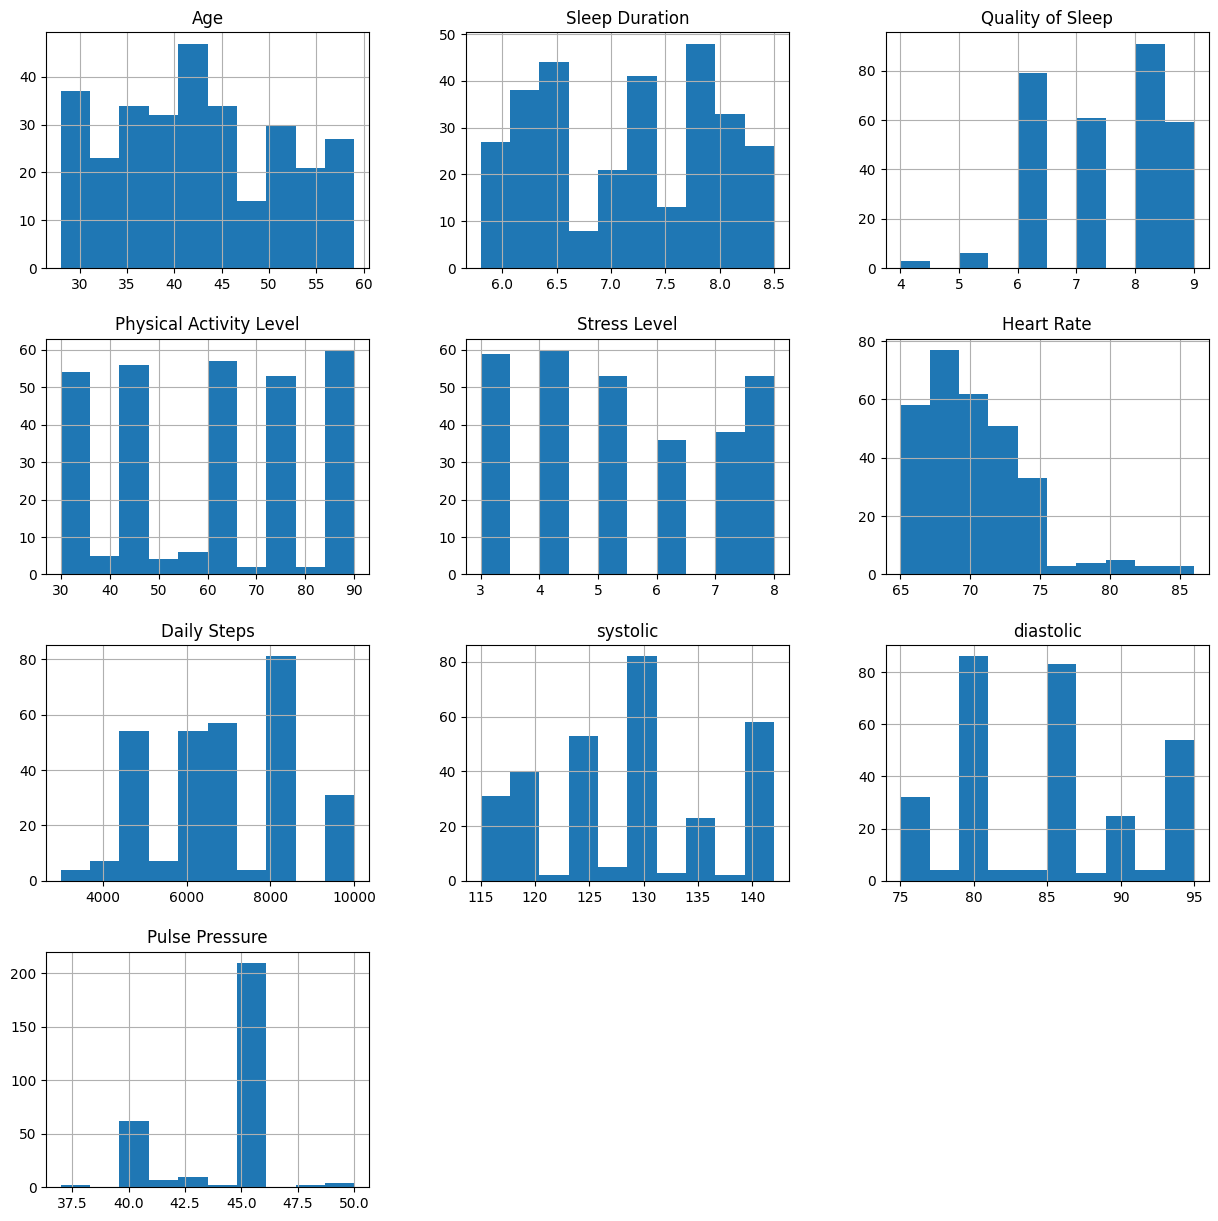

In [38]:
train_set[numericas].hist(figsize = (15,15))
plt.show()

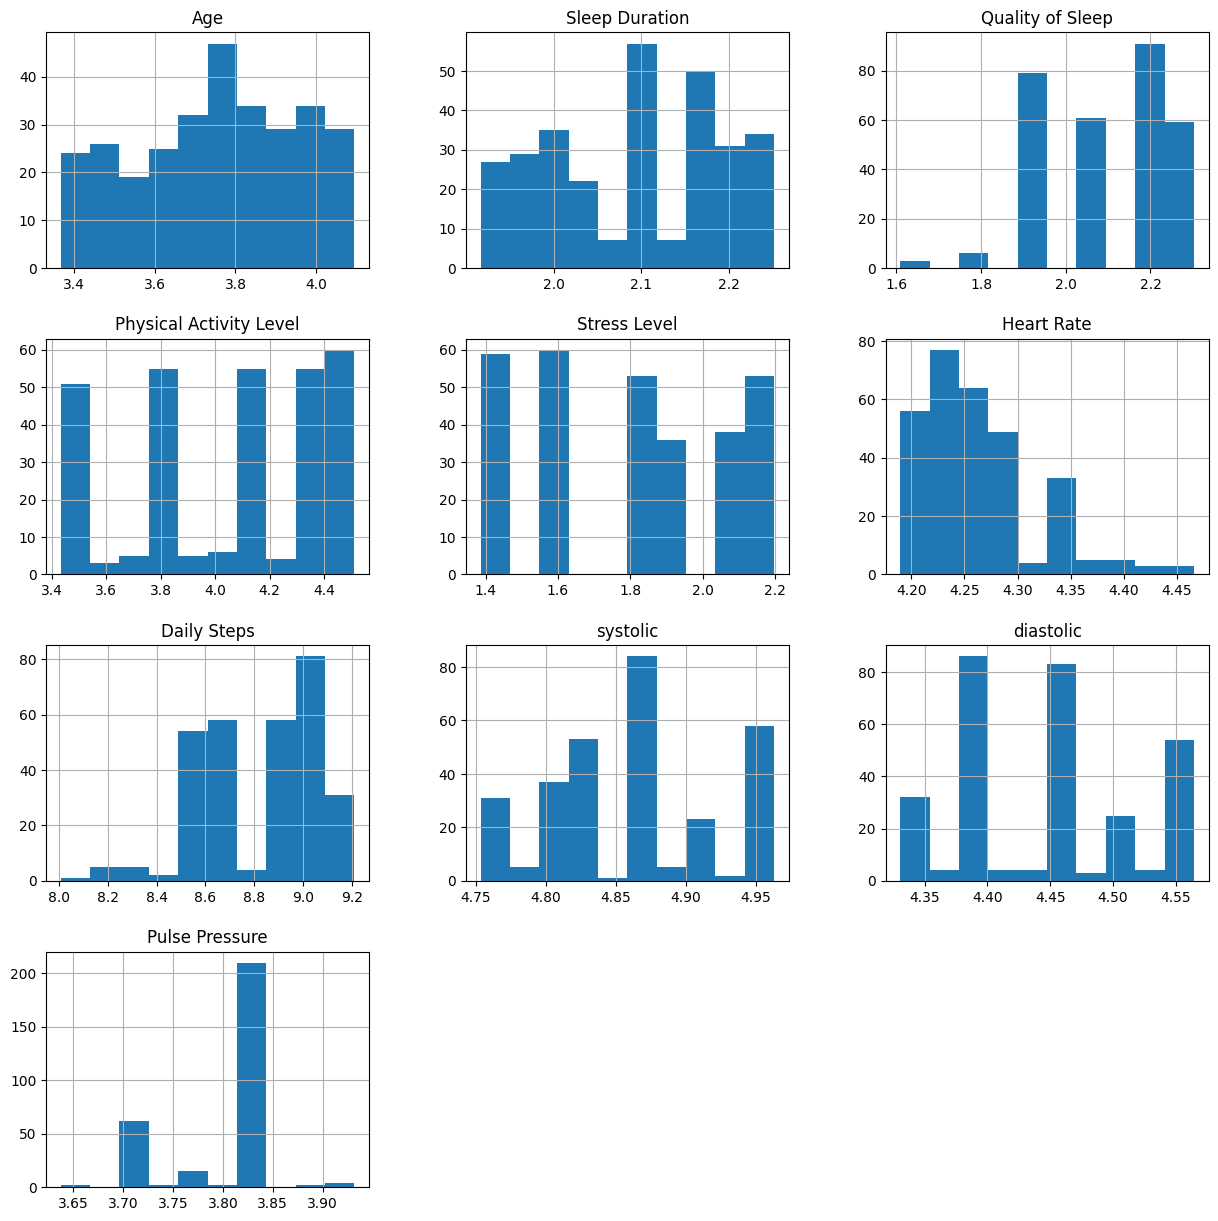

In [39]:
log = np.log1p(train_set[numericas])
log.hist(figsize=(15,15));

## Los datos se ven bien centrados, he probado de pasarle una transformación logarítmica pero no hay diferencia significativa 

## Vamos a hacer las mismas transformaciones a los datos de test

In [41]:
test_set.sample(5)

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
Person ID,,,,,,,,,,,,
232,Male,44,Salesperson,6.3,6,45,7,Overweight,130/85,72,6000,1
74,Male,33,Doctor,6.1,6,30,8,Normal,125/80,72,5000,0
346,Female,57,Nurse,8.2,9,75,3,Overweight,140/95,68,7000,1
23,Male,30,Doctor,7.7,7,75,6,Normal,120/80,70,8000,0
362,Female,59,Nurse,8.2,9,75,3,Overweight,140/95,68,7000,1


In [42]:
test_set.reset_index(inplace=True)
test_set.drop(columns = 'Person ID', inplace=True)
test_set.rename(columns = {'Sleep Disorder':'target'}, inplace=True)
# vamos a separar la columna de 'blood pressure' y vamos a calcular la presión del pulso
test_set[['systolic','diastolic']] = test_set['Blood Pressure'].str.extract(r'(\d+)/(\d+)', expand=True)
test_set.drop(columns='Blood Pressure', inplace=True)
test_set['systolic'] = test_set['systolic'].astype(int)
test_set['diastolic'] = test_set['diastolic'].astype(int)
test_set['Pulse Pressure'] = test_set['systolic'] - test_set['diastolic']
# vamos a codificar esas features categóricas
test_set['Gender_code'] = test_set['Gender'].apply(lambda x: 0 if x == 'Male' else 1)
# vamos a unir 'normal' con 'normal weight' y 'overweight' con 'obese' porque indican lo mismo
test_set['BMI Category'] = test_set['BMI Category'].map({'Normal Weight': 'Normal','Normal':'Normal', 'Overweight':'Overweight', 'Obese': 'Overweight'})
test_set['BMI Category_code'] = test_set['BMI Category'].apply(lambda x: 0 if x == 'Normal' else 1)
dummies_test = pd.get_dummies(test_set['Occupation']).astype(int)
test_set = pd.concat([test_set, dummies_test], axis = 1)

In [43]:
X_test = test_set.drop(columns = 'target')
y_test = test_set['target']

## Selección de features

He probado diferentes métodos para seleccionar las mejores features, incluyendo `mutual_info_classif`, `test de hipótesis`, `SelectFromModel`, `RFE`, `SFS`, `feature importance`, `Lasso`, `hard voting` y `selección manual`. Tras comparar el rendimiento de los modelos con cada enfoque, elegí estas variables con el `select from model` por ofrecer el mejor equilibrio entre precisión y utilidad.

In [44]:
mutual_info_classif
X = train_set[numericas]
y = train_set['target']

mic = mutual_info_classif(X, y)
print(pd.Series(mic, index=X.columns).sort_values(ascending=False))

systolic                   0.358599
diastolic                  0.340943
Sleep Duration             0.315532
Daily Steps                0.271977
Age                        0.263672
Physical Activity Level    0.183018
Pulse Pressure             0.168918
Stress Level               0.153716
Quality of Sleep           0.106148
Heart Rate                 0.102002
dtype: float64


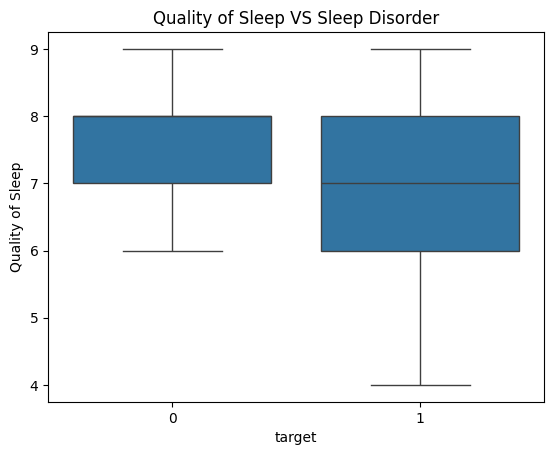

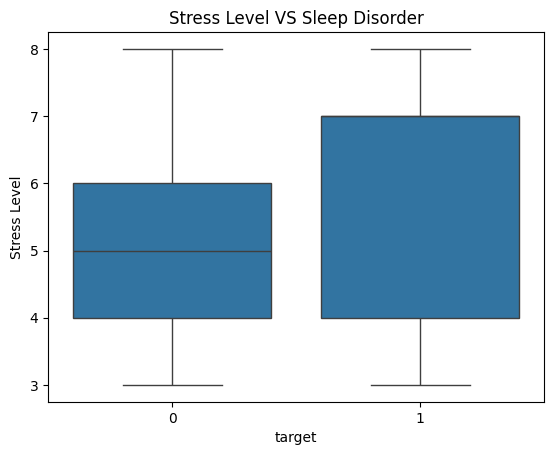

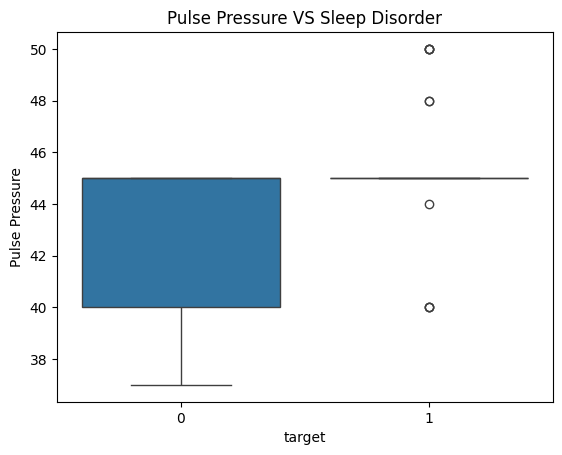

In [45]:
lista = ['Quality of Sleep', 'Stress Level', 'Pulse Pressure']
for x in lista:
    plt.figure()
    sns.boxplot(data=train_set, x='target', y=x)
    plt.title(f'{x} VS Sleep Disorder')

## Parece ser que las últimas tres son las peores, 'Quality of Sleep', 'Stress Level', 'Pulse Pressure', podemos probar modelos con estas features y sin estas features, si son modelos de arboles por ejemplo, quizás les funciona bien, podemos probar con test de Mann-Whitney U para ver que resultado tiene, ya que seria un contraste de categorica binaria con numérica

## Test de Mann-Whitney U

In [46]:
for x in lista:
    grupo_a = train_set.loc[train_set.target == 0][x]
    grupo_b = train_set.loc[train_set.target == 1][x]
    u_stat, p_valor = mannwhitneyu(grupo_a, grupo_b)
    print('-',x,'-')
    print("Estadístico U:", u_stat)
    print("Valor p:", p_valor)

    if p_valor < 0.05:
        print('Hay diferencia estadísticamente significativa')
    else:
        print('No hay diferencia suficiente')
    print('------------------------------')

- Quality of Sleep -
Estadístico U: 14700.0
Valor p: 5.277403177210805e-08
Hay diferencia estadísticamente significativa
------------------------------
- Stress Level -
Estadístico U: 8682.5
Valor p: 0.003116433630214749
Hay diferencia estadísticamente significativa
------------------------------
- Pulse Pressure -
Estadístico U: 6011.5
Valor p: 3.7269868670039093e-16
Hay diferencia estadísticamente significativa
------------------------------


## Como vemos con un test estadístico rechazamos la hipótesis nula, tenemos confianza estadística, hay relación entre los valores

In [47]:
features_todas = categoricas_int + numericas

In [48]:
X_train = train_set[features_todas]
y_train = train_set['target']

In [49]:
# SelectFromModel
r_forest = RandomForestClassifier(random_state = 42)

selector_model = SelectFromModel(estimator= r_forest, threshold='median')
selector_model.fit(X_train, y_train)
select_from_model = selector_model.get_feature_names_out().tolist()
select_from_model

['Nurse',
 'BMI Category_code',
 'Age',
 'Sleep Duration',
 'Quality of Sleep',
 'Physical Activity Level',
 'Stress Level',
 'Heart Rate',
 'Daily Steps',
 'systolic',
 'diastolic',
 'Pulse Pressure']

## Voy a hacer un test de hipótesis a estas features que son las que usaremos

In [50]:
lista_num = select_from_model + [target]

In [51]:
for x in lista_num:
    grupo_a = train_set.loc[train_set.target == 0][x]
    grupo_b = train_set.loc[train_set.target == 1][x]
    u_stat, p_valor = mannwhitneyu(grupo_a, grupo_b)
    print('-',x,'-')
    print("Estadístico U:", u_stat)
    print("Valor p:", p_valor)

    if p_valor < 0.05:
        print('Hay diferencia estadísticamente significativa')
    else:
        print('No hay diferencia suficiente')
    print('------------------------------')

- Nurse -
Estadístico U: 6801.5
Valor p: 4.770633582427406e-15
Hay diferencia estadísticamente significativa
------------------------------
- BMI Category_code -
Estadístico U: 2128.0
Valor p: 1.9243671628516113e-43
Hay diferencia estadísticamente significativa
------------------------------
- Age -
Estadístico U: 5137.5
Valor p: 1.0056724569177982e-14
Hay diferencia estadísticamente significativa
------------------------------
- Sleep Duration -
Estadístico U: 15014.0
Valor p: 1.16775103569525e-08
Hay diferencia estadísticamente significativa
------------------------------
- Quality of Sleep -
Estadístico U: 14700.0
Valor p: 5.277403177210805e-08
Hay diferencia estadísticamente significativa
------------------------------
- Physical Activity Level -
Estadístico U: 10221.5
Valor p: 0.4061957203875094
No hay diferencia suficiente
------------------------------
- Stress Level -
Estadístico U: 8682.5
Valor p: 0.003116433630214749
Hay diferencia estadísticamente significativa
-------------

## Todas las features menos dos tienen diferencia estadísticamente significativa, aun así, esas dos, que son, Physical Activity Level y Daily Steps las voy a dejar porque son importantes para la salud el deporte

## Seguimos con el resto de métodos de selección de features

In [52]:
# RFE
rfe = RFE(estimator= r_forest)
rfe.fit(X_train, y_train)
rfe.transform(X_train)
RFEv = rfe.get_feature_names_out().tolist()

In [53]:
# hard-voting

features_hard_voting = select_from_model + RFEv + select_from_model
votos = Counter(features_hard_voting)

In [54]:
seleccion = [x for x,y in votos.most_common(10)]

In [55]:
# Feature importance

r_forest.fit(X_train, y_train)

importances = r_forest.feature_importances_
feature_names = X_train.columns

features_importance = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)

## Hacemos un filtrado para quitar ruido

In [56]:
feature_importance = [x for x,y in features_importance.items() if y >= 0.01]

In [57]:
# LASSO
modelo = Lasso(alpha=0.01).fit(X_train, y_train)

importance = np.abs(modelo.coef_)
lasso_importance = pd.Series(importance, index=X_train.columns).sort_values(ascending=False)

## Hacemos un filtrado para quitar ruido

In [58]:
lasso_import = [x for x,y in lasso_importance.items() if y >= 0.01]

## Voy a preparar un diccionario para probar con diferentes features, también, voy a probar de quitar algunas features que al principio generó duda de si serían útil o no

In [59]:
no_stress = [x for x in features_todas if x != 'Stress Level']
no_systolic = [x for x in features_todas if x != 'systolic']
no_diastolic = [x for x in features_todas if x != 'diastolic']
solo_pulse_pressure = [x for x in no_diastolic if x != 'systolic']
solo_diastolic = [x for x in no_systolic if x != 'Pulse Pressure']
solo_systolic = [x for x in no_diastolic if x != 'Pulse Pressure']

In [60]:
posibles_features = {
    'todas' : features_todas,
    'SFM' : select_from_model,
    'RFE' : RFEv,
    'SFS' : select_from_model,
    'todas_no_stress' : no_stress,
    'todas_no_systolic' : no_systolic,
    'todas_no_diastolic' : no_diastolic,
    'solo_pulse_pressure' : solo_pulse_pressure,
    'solo_diastolic' : solo_diastolic,
    'solo_systolic' : solo_systolic,
    'hard voting':seleccion,
    'feature_importance': feature_importance,
    'lasso_import' : lasso_import
}

## Voy a pasar las features con tipo 'object' a catboost y lightgbm, tengo que modificar el diccionario de las features para poderlo hacer

In [61]:
cat_gbm = {
    'Gender_code': 'Gender',
    'Accountant' : 'Occupation',
    'Doctor' : 'Occupation',
    'Engineer' :'Occupation',
    'Lawyer' : 'Occupation',
    'Manager' : 'Occupation',
    'Nurse' : 'Occupation',
    'Sales Representative' : 'Occupation',
    'Salesperson' : 'Occupation',
    'Scientist' : 'Occupation',
    'Software Engineer' : 'Occupation',
    'Teacher' : 'Occupation',
    'BMI Category_code': 'BMI Category'
}

## Aquí soluciono y creo un nuevo diccionario con las numéricas y las categóricas de tipo 'object'

In [62]:
dict_features_cat_gbm = {}
for x,y in posibles_features.items():
    lista = []
    for a in y:
        if a in cat_gbm:
            lista.append(cat_gbm[a])
        else: 
            lista.append(a)
    dict_features_cat_gbm[x] = list(set(lista))

## Comparación de Modelos

Con un bucle probé diferentes modelo (baseline):

* `RandomForestClassifier`
* `XGBClassifier`
* `LGBMClassifier`
* `GradientBoostingClassifier`
* `CatBoostClassifier`
* `DecisionTreeClassifier`
* `LogisticRegression`
* `KNeighborsClassifier`
* `SVC`

Todos fueron evaluados mediante **validación cruzada** con los scorings:
**`recall`**, **`f1`** y **`roc_auc`**.

Comparé los resultados entre ellos mismos, seleccioné los modelos con mejor rendimiento e hice pruebas, ajusté hiperparámetros a cada modelo. La elección final del mejor modelo fue en base a obtener:

* **`classification_report`**
* **Importancia de variables (`feature_importances_`)**
* **`ConfusionMatrixDisplay`**

Viendo esto, me pude asegurar que lo que estaba eligiendo estaba funcionando bien.

In [63]:
#Instanciamos los modelos
rforest = RandomForestClassifier(random_state= 42)
xgb = XGBClassifier(verbosity = 0, random_state= 42)
lgb = LGBMClassifier(verbose = -1, random_state= 42)
gradient = GradientBoostingClassifier(random_state= 42)
cat= CatBoostClassifier(verbose = False, random_state= 42)
tree = DecisionTreeClassifier(random_state= 42)
linear = LogisticRegression()
knn = KNeighborsClassifier()
svc = SVC()

#instanciamos el escalador para los modelos sensibles a la escala
scaler = StandardScaler()

# cremos un diccionario con todos los modelos
modelos = {
    'random forest' : rforest,
    'xgboost' : xgb,
    'light gbm' : lgb,
    'gradient' : gradient,
    'cat':cat,
    'tree':tree,
    'linear':linear,
    'knn': knn,
    'svc': svc
}

# asignamos las features con tipo 'category' para los modelos de catboost y lightgbm que aceptan este tipo de variables
categoricas = ['Gender', 'Occupation', 'BMI Category']

# vamos a hacer un bucle que depende del modelo se haraán unas cosas u otras y todo se guarda en un diccionario para visualizarlo en un dataframe
resultados = []
for nombre, modelo in modelos.items():
    if nombre in ['linear','knn', 'svc']:
        for clave, valor in posibles_features.items():
            X_train_escalado = scaler.fit_transform(X_train[valor])
            cross = cross_validate(modelo, X_train_escalado, y_train, cv = 5 , scoring = ['recall', 'f1', 'roc_auc'])
            resultados.append({
                'modelo': nombre,
                'metodo seleccion features' : clave,
                'recall' : np.mean(cross['test_recall']),
                'f1' : np.mean(cross['test_f1']),
                'roc_auc' : np.mean(cross['test_roc_auc'])
            })
            
    elif nombre == 'light gbm':
        for clave, valor in dict_features_cat_gbm.items():
            category = [x for x in categoricas if x in valor] # selecciona las categoricas que usamos en este momento para asignarlas al modelo
            lgb_2 = LGBMClassifier(verbose = -1, random_state= 42, categorical_feature=category) # aqui se le informa cuales son de tipo 'category'
            cross = cross_validate(lgb_2, train_set[valor], y_train, cv = 5 , scoring = ['recall', 'f1', 'roc_auc'])
            resultados.append({
                'modelo': 'lgb',
                'metodo seleccion features' : clave,
                'recall' : np.mean(cross['test_recall']),
                'f1' : np.mean(cross['test_f1']),
                'roc_auc' : np.mean(cross['test_roc_auc'])
            })
                
    elif nombre == 'cat':
        for clave, valor in dict_features_cat_gbm.items():
            category = [x for x in categoricas if x in valor]
            cat_2= CatBoostClassifier(verbose = False, random_state= 42, cat_features= category)
            cross = cross_validate(cat_2, train_set[valor], y_train, cv = 5 , scoring = ['recall', 'f1', 'roc_auc'])
            resultados.append({
                'modelo': 'cat',
                'metodo seleccion features' : clave,
                'recall' : np.mean(cross['test_recall']),
                'f1' : np.mean(cross['test_f1']),
                'roc_auc' : np.mean(cross['test_roc_auc'])
            })
                
    else:
        for clave, valor in posibles_features.items():
            cross = cross_validate(modelo, train_set[valor], y_train, cv = 5 , scoring = ['recall', 'f1', 'roc_auc'])
            resultados.append({
                'modelo': nombre,
                'metodo seleccion features' : clave,
                'recall' : np.mean(cross['test_recall']),
                'f1' : np.mean(cross['test_f1']),
                'roc_auc' : np.mean(cross['test_roc_auc'])
            })   

In [64]:
resultado_baseline = pd.DataFrame(resultados).sort_values(by= 'recall', ascending=False)

In [65]:
pd.set_option('display.max_rows', None)

## Vamos a ver los resultados que tenemos con un filtrado para así ser más selectivo

In [66]:
resultado_baseline.loc[(resultado_baseline['recall'] > 0.91) & (resultado_baseline['roc_auc'] > 0.9) & (resultado_baseline['metodo seleccion features'] != 'SFS')]

,modelo,metodo seleccion features,recall,f1,roc_auc
48,gradient,solo_systolic,0.919,0.918357,0.903549
45,gradient,todas_no_diastolic,0.919,0.918357,0.904012
37,lgb,feature_importance,0.919,0.918357,0.904151
38,lgb,lasso_import,0.919,0.915506,0.902562
39,gradient,todas,0.919,0.918357,0.902390
40,gradient,SFM,0.919,0.918357,0.907643
41,gradient,RFE,0.919,0.918357,0.906073
33,lgb,solo_pulse_pressure,0.919,0.914587,0.902948
34,lgb,solo_diastolic,0.919,0.918357,0.904945
36,lgb,hard voting,0.919,0.918357,0.902432


In [67]:
pd.reset_option('display.max_rows')

|Modelo|Features|Recall|F1|roc_auc|
|-|-|-|-|-|
97	|SVC|SFM|0.919|0.922|0.934|
98	|SVC|RFE|0.919|0.922|0.931|
50	|CatBoost|RFE|0.919|0.922|0.905|
54	|CatBoost|todas_no_diastolic|0.919|0.922|0.906|
49	|CatBoost|SFM|0.919|0.922|0.905|
23	|XGBoost|lasso_import|0.919|0.922|0.901|
58	|CatBoost|feature_importance|0.919|0.922|0.905|

## Vamos a hacer validación cruzada para ver los resultados

In [68]:
#Instanciamos el modelo
rforest = RandomForestClassifier(random_state= 42)

In [69]:
resultados = []
cross = cross_validate(rforest, train_set[select_from_model], y_train, cv = 5 , scoring = ['recall', 'f1', 'roc_auc'])
resultados.append({
        'recall' : np.mean(cross['test_recall']),
        'f1' : np.mean(cross['test_f1']),
        'roc_auc' : np.mean(cross['test_roc_auc'])
    })

In [70]:
resultado_baseline = pd.DataFrame(resultados)

In [71]:
resultado_baseline

,recall,f1,roc_auc
0,0.894,0.904468,0.912773


## El modelo RandomForest da unos resultados muy buenos de recall

In [72]:

# Aquí iria el proceso de pruebas con los mejores modelos y diferentes features, vamos directos al que funciona y he usado


## Al modelo le vamos a pasar unos hiperparámetros y un GridSearchCV

In [73]:
# RandomForestClassifier

rf2 = RandomForestClassifier(random_state=42)
param_grid_rf2 = {
    'n_estimators': [100, 200,300],
    'max_depth': [2, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_rf2 = GridSearchCV(
    rf2,
    param_grid_rf2,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    verbose=1
)
grid_rf2.fit(train_set[select_from_model], y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 5, 10], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200, 300]},
             scoring='recall', verbose=1)

In [74]:
modelo1_mejores_params = grid_rf2.best_params_

In [75]:
grid_rf2.best_params_

{'max_depth': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [76]:
y_pred = grid_rf2.best_estimator_.predict(test_set[select_from_model])
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97        43
           1       0.97      0.94      0.95        32

    accuracy                           0.96        75
   macro avg       0.96      0.96      0.96        75
weighted avg       0.96      0.96      0.96        75



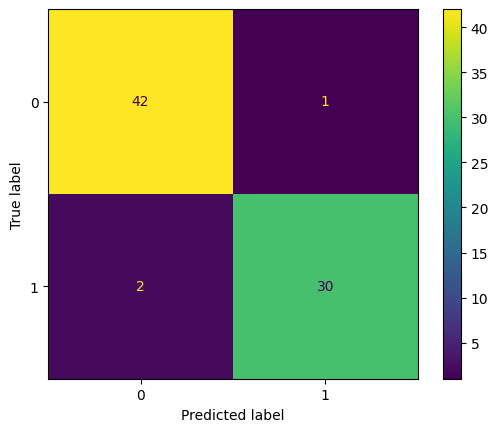

In [77]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred);

## Nos indica que ha clasificado a 42 sin problema de sueño que no tienen problema y a 1 que tiene problema del sueño que realmente no tiene, para los que tienen problema de sueño a clasificado 30 como que tienen problemas y a 2 que no tienen y realmente si tienen problema de sueño 

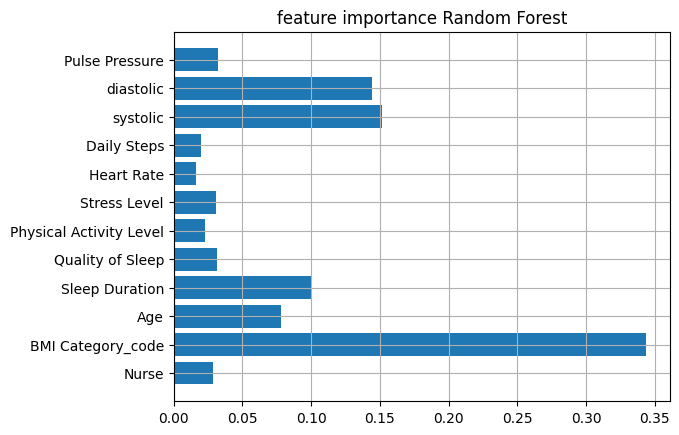

In [78]:
rf2.fit(train_set[select_from_model], y_train)
plt.barh(train_set[select_from_model].columns,rf2.feature_importances_)
plt.title('feature importance Random Forest')
plt.grid(True);

## RandomForest nos da una buena distribución de la importancia de las features en el modelo

# Ahora voy a hacer un Pipeline para la transformación de datos para la producción y guardar el modelo y el pipeline, necesito cargar los datos y hacer las mismas transformaciones

In [79]:
dataset = pd.read_csv('./src/data/Sleep_Health_and_Lifestyle.csv')

In [80]:
dataset.drop(columns='Person ID', inplace=True)
dataset.drop(columns='Gender', inplace=True)
dataset['Sleep Disorder'] = dataset['Sleep Disorder'].fillna('NaN')
mapeo = {'NaN':0, 'Sleep Apnea':1, 'Insomnia':1}
dataset['Sleep Disorder'] = dataset['Sleep Disorder'].map(mapeo)
dataset.rename(columns={'Sleep Disorder':'target'}, inplace=True)
dataset[['systolic','diastolic']] = dataset['Blood Pressure'].str.extract(r'(\d+)/(\d+)', expand=True)
dataset.drop(columns='Blood Pressure', inplace=True)
dataset['systolic'] = dataset['systolic'].astype(int)
dataset['diastolic'] = dataset['diastolic'].astype(int)
dataset['BMI Category'] = dataset['BMI Category'].map({'Normal Weight': 'Normal','Normal':'Normal', 'Overweight':'Overweight', 'Obese': 'Overweight'})
dummies_test = pd.get_dummies(dataset['Occupation']).astype(int)
dataset = pd.concat([dataset, dummies_test], axis = 1)
dataset['BMI Category'] = dataset['BMI Category'].apply(lambda x: 0 if x == 'Normal' else 1)
dataset['Pulse Pressure'] = dataset['systolic'] - dataset['diastolic']

In [81]:
profesiones = ['Occupation','Accountant','Doctor','Engineer','Lawyer','Manager','Sales Representative','Salesperson','Scientist','Software Engineer','Teacher'] 

In [82]:
cols = [x for x in dataset.columns if x not in profesiones]

In [83]:
cols = cols + ['Pulse Pressure']

In [84]:
dataset[cols].sample(5)

,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,target,systolic,diastolic,Nurse,Pulse Pressure,Pulse Pressure
229,44,6.3,6,45,7,1,72,6000,1,130,85,0,45,45
99,36,7.1,8,60,4,0,68,7000,0,115,75,0,40,40
71,33,6.1,6,30,8,0,72,5000,0,125,80,0,45,45
39,31,7.6,7,75,6,0,70,8000,0,120,80,0,40,40
196,43,6.5,6,45,7,1,72,6000,1,130,85,0,45,45


In [85]:
X_t = dataset[cols].drop(columns='target')
y_t = dataset[cols]['target']

## Después de hacer las transformaciones como anteriormente, vamos a construir unas funciones para pipeline

In [86]:
# para sacar el bmi
def bmi(X):
    X = X.copy()
    X['bmi'] = X['peso'] / (X['altura'] ** 2)
    return X

# clasifica el bmi segun el bmi obtenido
def bmi_clasificador(X):
    X = X.copy()
    X['BMI Category'] = (X['bmi'] >= 25.0).astype(int)
    return X[['BMI Category']]

# hace el cálculo para sacar la presion del pulso
def Pulse_Pressure(X):
    X = X.copy()
    X['Pulse Pressure'] = X['systolic'] - X['diastolic']
    return X
    
# codifica según la respuesta del formulario
def nurse_func(X):
    return (X == 'Sí').astype(int)

## Vamos a hacer el pipeline

In [87]:
# primero metemos en pipeline estos dos pasos, porque primero va un paso del calculo y luego codificarla a 0 o 1
bmi_1 = FunctionTransformer(bmi)
bmi_2 = FunctionTransformer(bmi_clasificador)

pipeline_bmi = Pipeline([
    ('bmi_num', bmi_1),
    ('bmi_code', bmi_2)
])
#para pulso solo hay un paso
pulso = FunctionTransformer(Pulse_Pressure)
nurse = FunctionTransformer(nurse_func)

# metemos todo en el columntransformer para que se hagan los cambios
preprocessor = ColumnTransformer(
    transformers=[
        ('bmi', pipeline_bmi, ['peso', 'altura']),
        ('pulse_pressure', pulso, ['systolic', 'diastolic']),
        ('nurse', nurse, ['Nurse'])
    ],
    remainder='passthrough'
)
# paso el passthrough_transformer con 'systolic', 'diastolic' para que aparezcan también en el dataset para el modelo
# el remainder se pone en 'passthrough' para que no afecte al resto de columnas

# este es el pipeline con todo dentro
pipeline1 = Pipeline([
    ('preprocessor', preprocessor)
])

## Tenemos que hacer el fit del pipeline con datos creados por mi, porque lo que el usuario introduzca yo ya lo tengo transformado como el 'bmi', 'presión del pulso'...

In [88]:
pipe_1 = pd.DataFrame({
                'Nurse':'Sí',
                'Age':27,
                'Sleep Duration':6.1,
                'Quality of Sleep':6,
                'Physical Activity Level': 42,
                'Stress Level':6,
                'Heart Rate':77,
                'Daily Steps':4200,
                'systolic':126,
                'diastolic':83,
                'peso':70,
                'altura':1.80
}, index = dataset[cols].index)

In [89]:
pipe_1 = pipe_1.iloc[[0]]

In [90]:
pipeline1.fit(pipe_1)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('bmi',
                                                  Pipeline(steps=[('bmi_num',
                                                                   FunctionTransformer(func=<function bmi at 0x0000013DEDCDAE60>)),
                                                                  ('bmi_code',
                                                                   FunctionTransformer(func=<function bmi_clasificador at 0x0000013DEDCDB640>))]),
                                                  ['peso', 'altura']),
                                                 ('pulse_pressure',
                                                  FunctionTransformer(func=<function Pulse_Pressure at 0x0000013DEDCDA3B0>),
                                                  ['systolic', 'diastolic']),
                                                 ('nurse',
                                                  FunctionTransformer(func=<function nurse_func at 0x0000013DEDCDAB00>),
                                                  ['Nurse'])]))])

# Hacemos un fit del modelo RandomForest también para poder guardarlo, en este caso no lo pongo dentro del pipeline, irá fuera

In [91]:
# ponemos el modelo con los mejores hiperparametros
modelo = RandomForestClassifier(random_state=42, **modelo1_mejores_params)
# se entrena el modelo con todos los datos que tenemos, este modelo es el definitivo
modelo.fit(X_t, y_t)

RandomForestClassifier(max_depth=2, random_state=42)

## Guardamos el modelo y el pipeline con joblib

In [92]:
joblib.dump(modelo, './src/models/modelo_entrenado_1_R_F.joblib')

['./src/models/modelo_entrenado_1_R_F.joblib']

In [93]:
joblib.dump(pipeline1, './src/models/pipeline_transformacion_1_R_F.joblib')

['./src/models/pipeline_transformacion_1_R_F.joblib']

### Construcción del Pipeline

Durante la construcción del pipeline especialmente para la transformación de datos, realizé diferentes pruebas y ajustes para asegurarme el buen funcionamiento en cada proceso para conseguir un flujo perfecto y robusto.

# **Fase 2**

## Ahora tenemos que clasificar si es insomnio o apnea del sueño, de esta forma podemos controlar mejor el 'recall' de si tiene problema o no porque es importante diferenciar bien, ahora queremos la metrica de 'precision'

## Necesito volver al dataset original para seleccionar esas dos opciones del target y hacerle las transformaciones

In [94]:
df2 = pd.read_csv('./src/data/Sleep_Health_and_Lifestyle.csv')

In [95]:
df2.drop(columns = 'Person ID', inplace=True)
df2.dropna(inplace=True)
df2.rename(columns = {'Sleep Disorder': 'target'}, inplace=True)

## El target es casi 50-50, muy igualado

In [96]:
df2['target'].value_counts(True)

target
Sleep Apnea    0.503226
Insomnia       0.496774
Name: proportion, dtype: float64

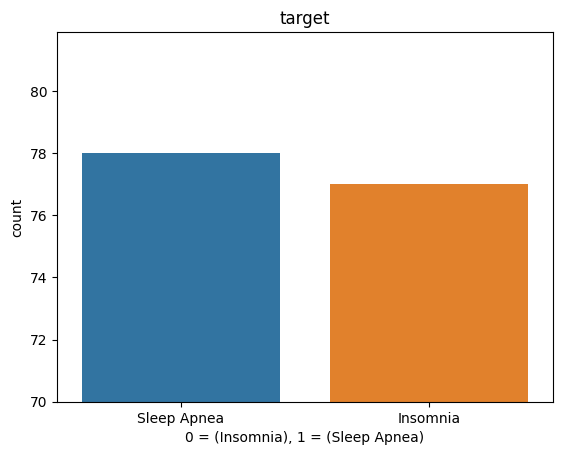

In [97]:
sns.countplot(df2, x= 'target', hue='target')
plt.xlabel('0 = (Insomnia), 1 = (Sleep Apnea)')
plt.title('target')
plt.ylim(70);

In [98]:
# lo codificamos
df2['target'] = df2['target'].map({'Insomnia':0, 'Sleep Apnea':1})

# Voy a hacer esta transformación antes del split porque como hay poco valores, luego con los modelos me da error por alguna profesión que no se encuentra, entonces así estarán todas ya que se hace con One-Hot-Encoding

In [99]:
dummies_train_2 = pd.get_dummies(df2['Occupation']).astype(int)
df2 = pd.concat([df2, dummies_train_2], axis = 1)

## Dividimos en train y test

In [100]:
train_set_2, test_set_2 = train_test_split(df2, test_size=0.2, random_state=42)

In [101]:
print(train_set_2.shape)
print(test_set_2.shape)

(124, 22)
(31, 22)


## Vamos a hacer las mismas transformaciones que arriba

In [102]:
# vamos a separar la columna de 'blood pressure' y vamos a calcular la presión del pulso
train_set_2[['systolic','diastolic']] = train_set_2['Blood Pressure'].str.extract(r'(\d+)/(\d+)', expand=True)
train_set_2.drop(columns='Blood Pressure', inplace=True)
train_set_2['systolic'] = train_set_2['systolic'].astype(int)
train_set_2['diastolic'] = train_set_2['diastolic'].astype(int)
train_set_2['Pulse Pressure'] = train_set_2['systolic'] - train_set_2['diastolic']
# vamos a codificar esas features categoricas
train_set_2['Gender_code'] = train_set_2['Gender'].apply(lambda x: 0 if x == 'Male' else 1)
# vamos a unir 'normal' con 'normal weight' y 'overweight' con 'obese' porque indican lo mismo
train_set_2['BMI Category'] = train_set_2['BMI Category'].map({'Normal Weight': 'Normal','Normal':'Normal', 'Overweight':'Overweight', 'Obese': 'Overweight'})
train_set_2['BMI Category_code'] = train_set_2['BMI Category'].apply(lambda x: 0 if x == 'Normal' else 1)

## Ahora con los datos de test

In [103]:
# vamos a separar la columna de 'blood pressure' y vamos a calcular la presión del pulso
test_set_2[['systolic','diastolic']] = test_set_2['Blood Pressure'].str.extract(r'(\d+)/(\d+)', expand=True)
test_set_2.drop(columns='Blood Pressure', inplace=True)
test_set_2['systolic'] = test_set_2['systolic'].astype(int)
test_set_2['diastolic'] = test_set_2['diastolic'].astype(int)
test_set_2['Pulse Pressure'] = test_set_2['systolic'] - test_set_2['diastolic']
# vamos a codificar esas features categoricas
test_set_2['Gender_code'] = test_set_2['Gender'].apply(lambda x: 0 if x == 'Male' else 1)
# vamos a unir 'normal' con 'normal weight' y 'overweight' con 'obese' porque indican lo mismo
test_set_2['BMI Category'] = test_set_2['BMI Category'].map({'Normal Weight': 'Normal','Normal':'Normal', 'Overweight':'Overweight', 'Obese': 'Overweight'})
test_set_2['BMI Category_code'] = test_set_2['BMI Category'].apply(lambda x: 0 if x == 'Normal' else 1)

In [104]:
X_test_2 = test_set_2.drop(columns='target')
y_test_2 = test_set_2['target']

## El siguiente paso es ver las features comparadas con el target para ver su distribución con forma de histogramas y gráficos de barras

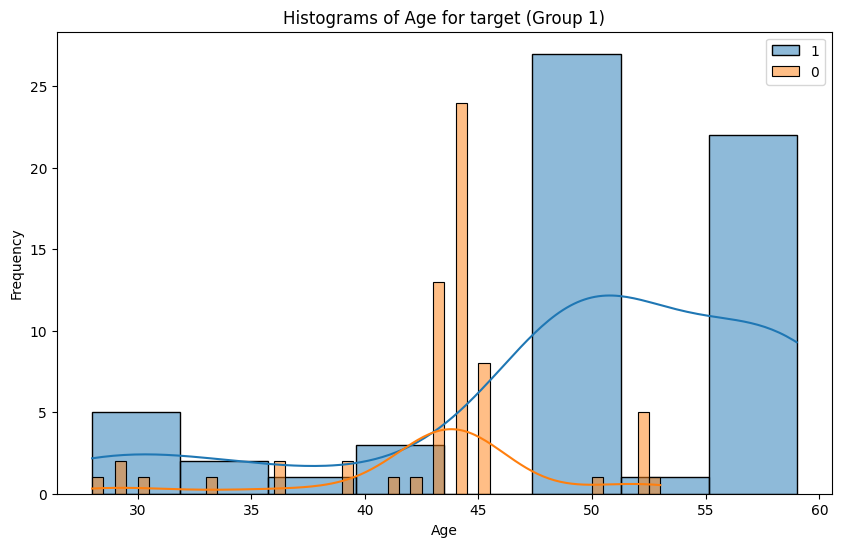

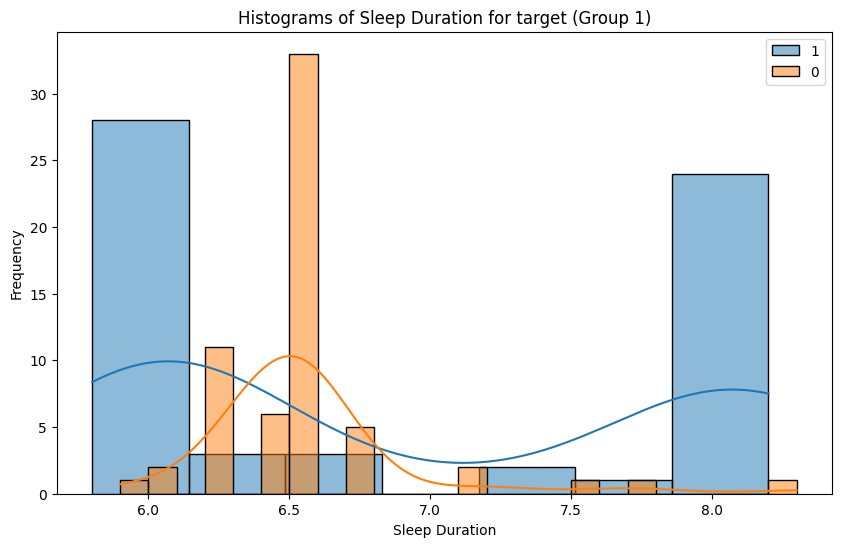

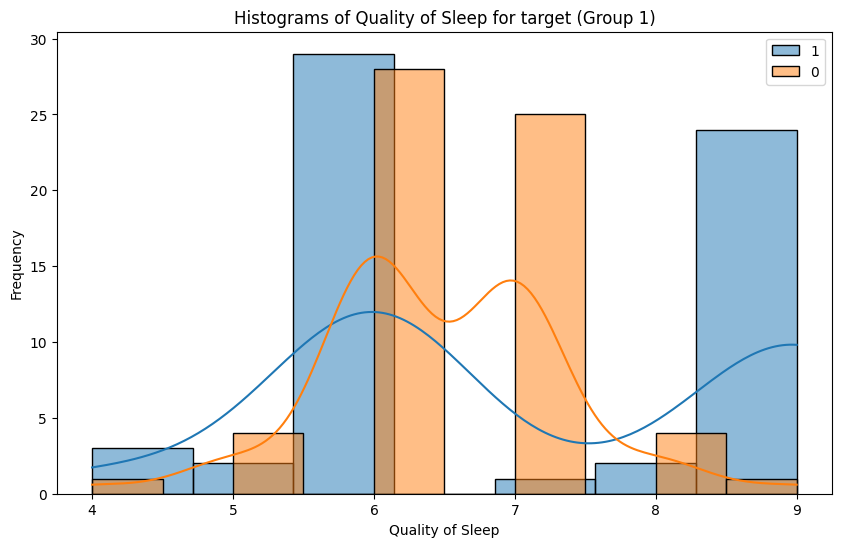

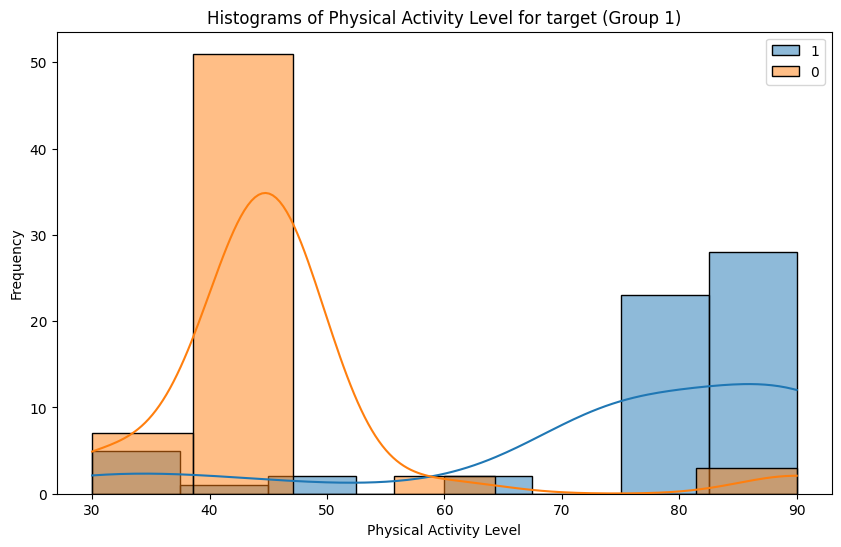

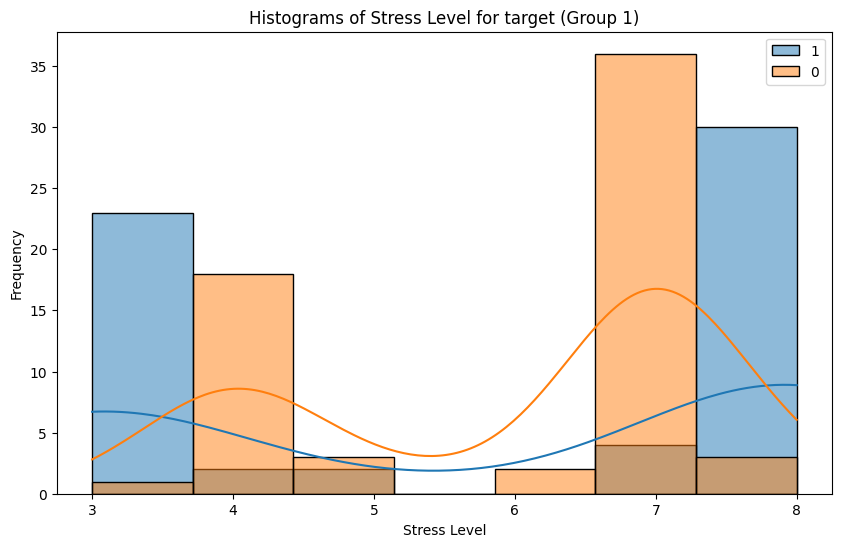

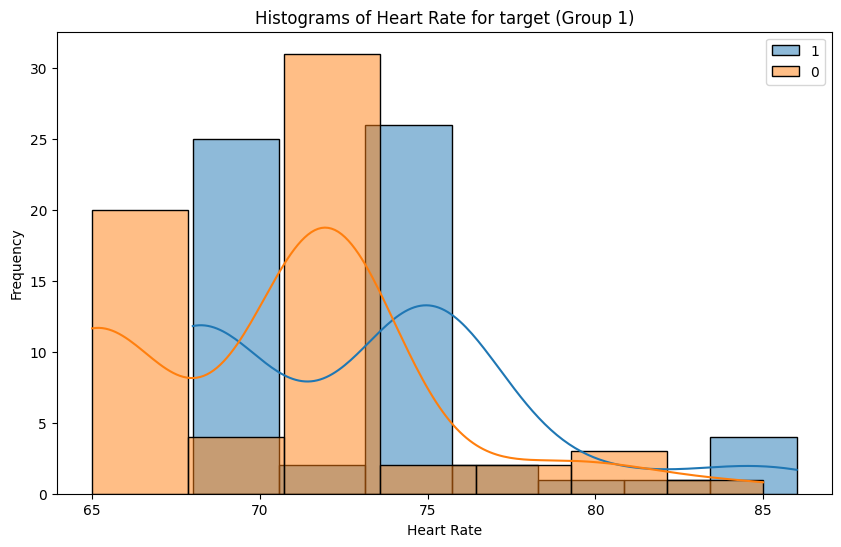

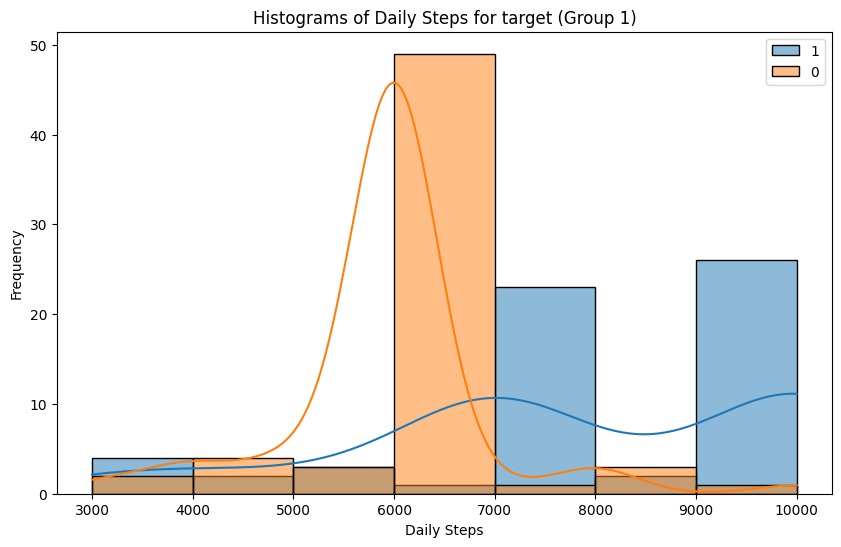

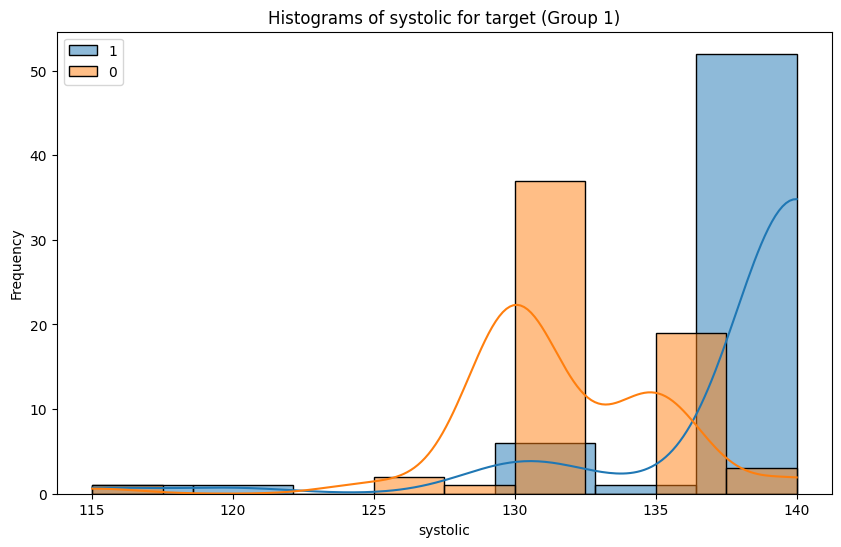

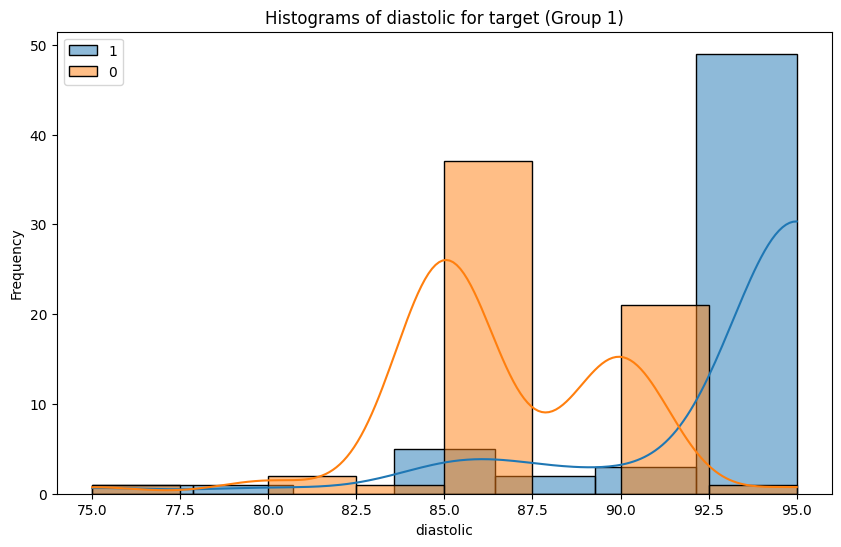

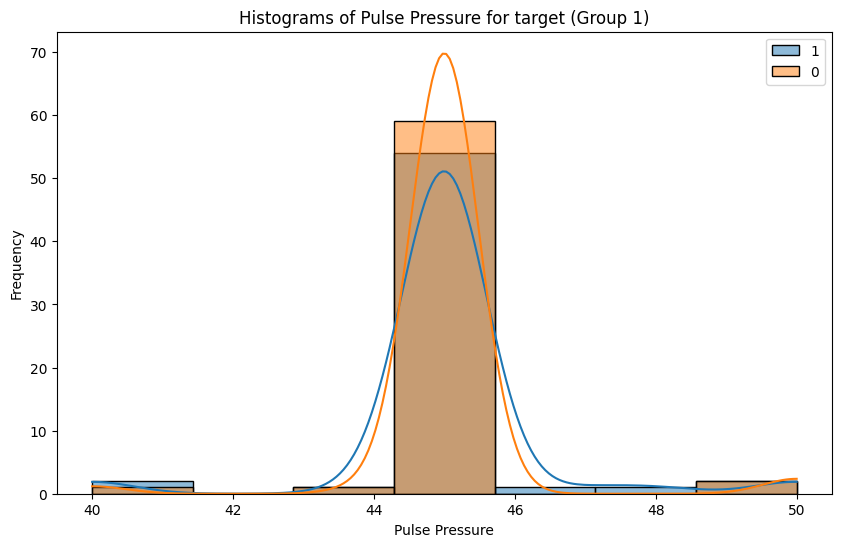

In [105]:
for x in numericas_features:
    plot_grouped_histograms(train_set_2, 'target', x, group_size=2)

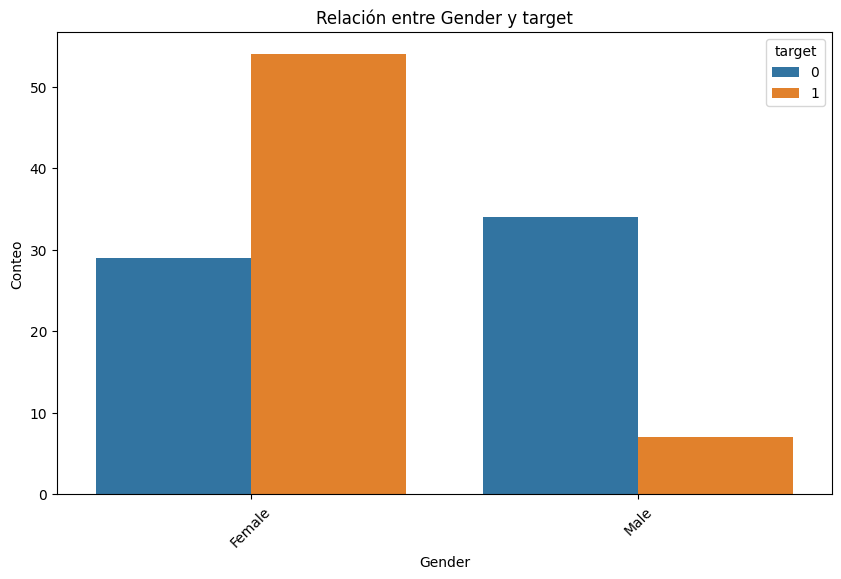

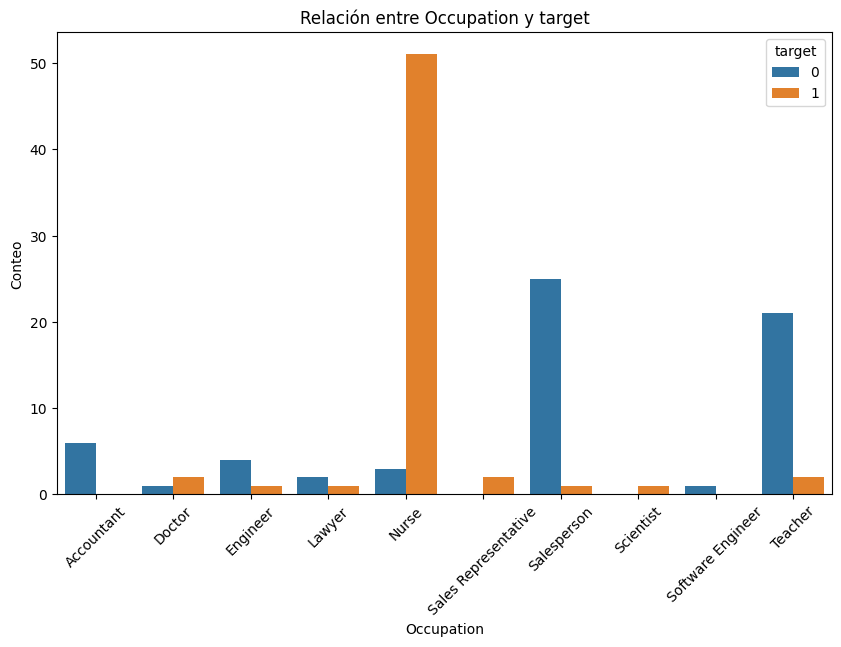

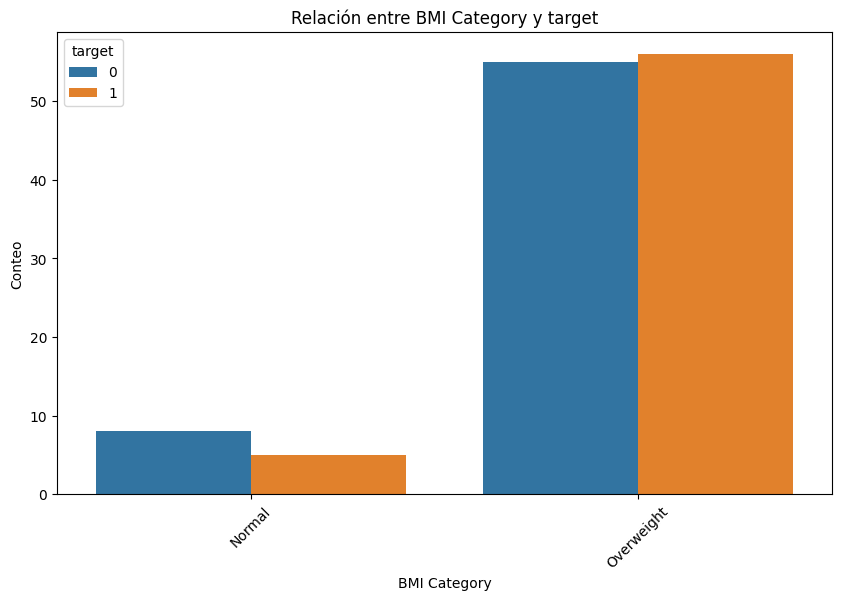

In [106]:
for x in cat_features:
    plot_categorical_relationship_fin(train_set_2, cat_col1=x, cat_col2='target', size_group=11)

## Se ve una buena relación entre las features contra el target, hay una diferencia entre los que no tienen problema del sueño y los que tienen problemas en el sueño.

In [107]:
targett = 'target'

## Vamos a ver la comparación de las features con el target, otra forma de verlo con pairplot de seaborn

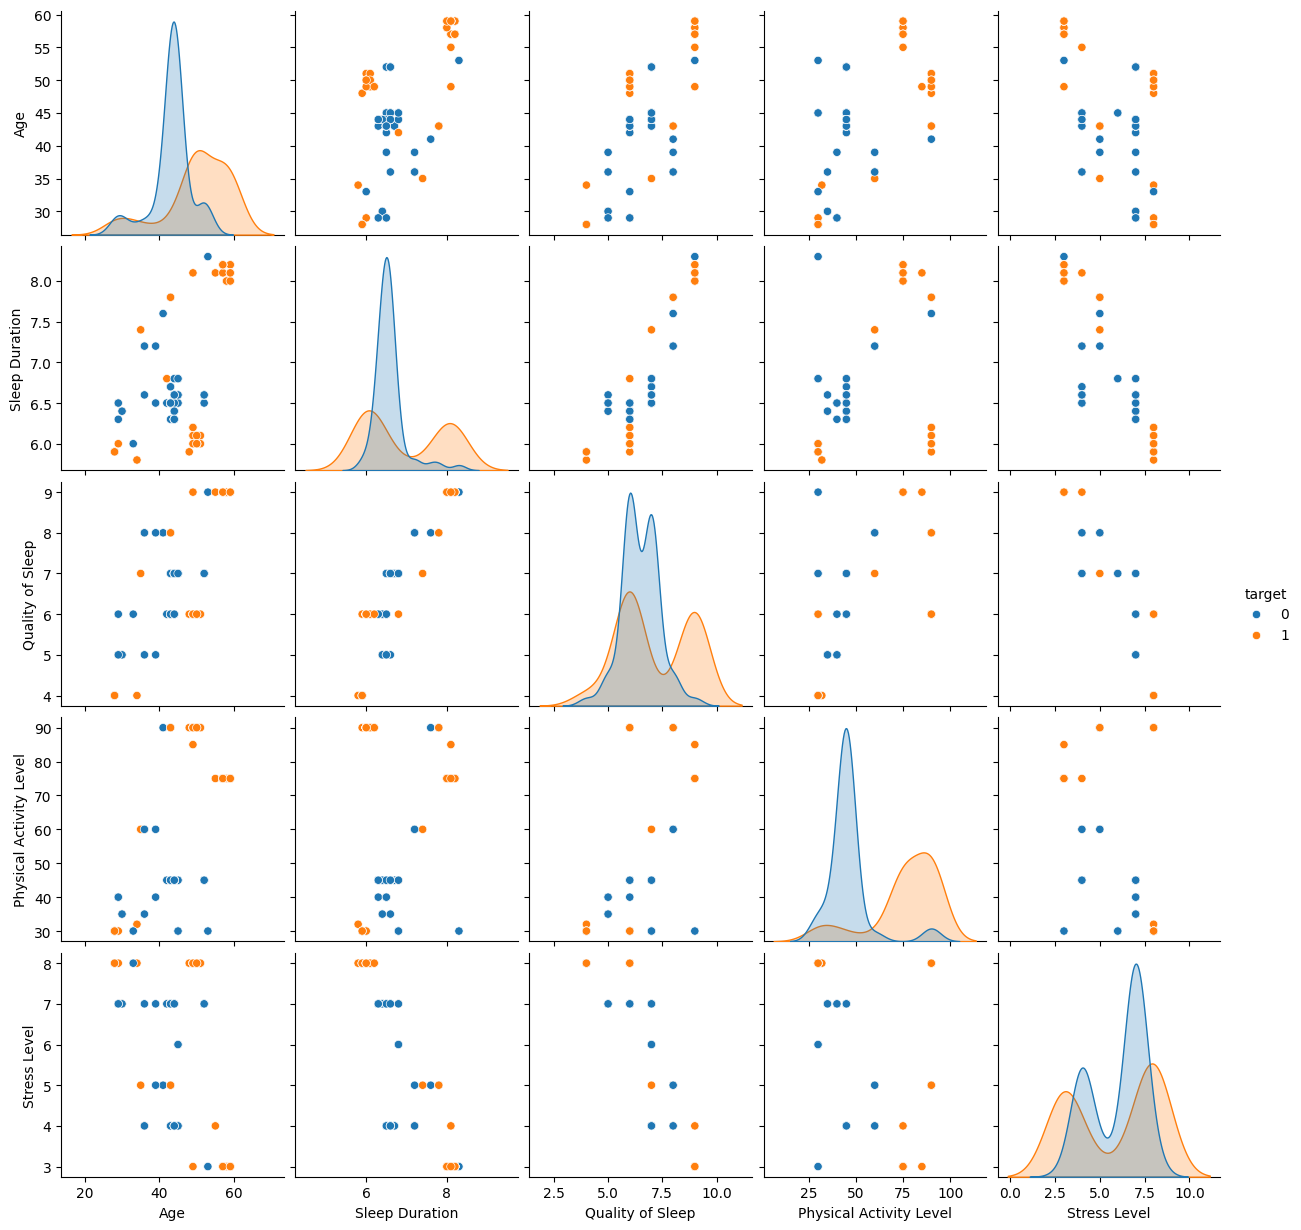

In [108]:
sns.pairplot(train_set_2[numericas[0:5] + [targett]], hue= targett);

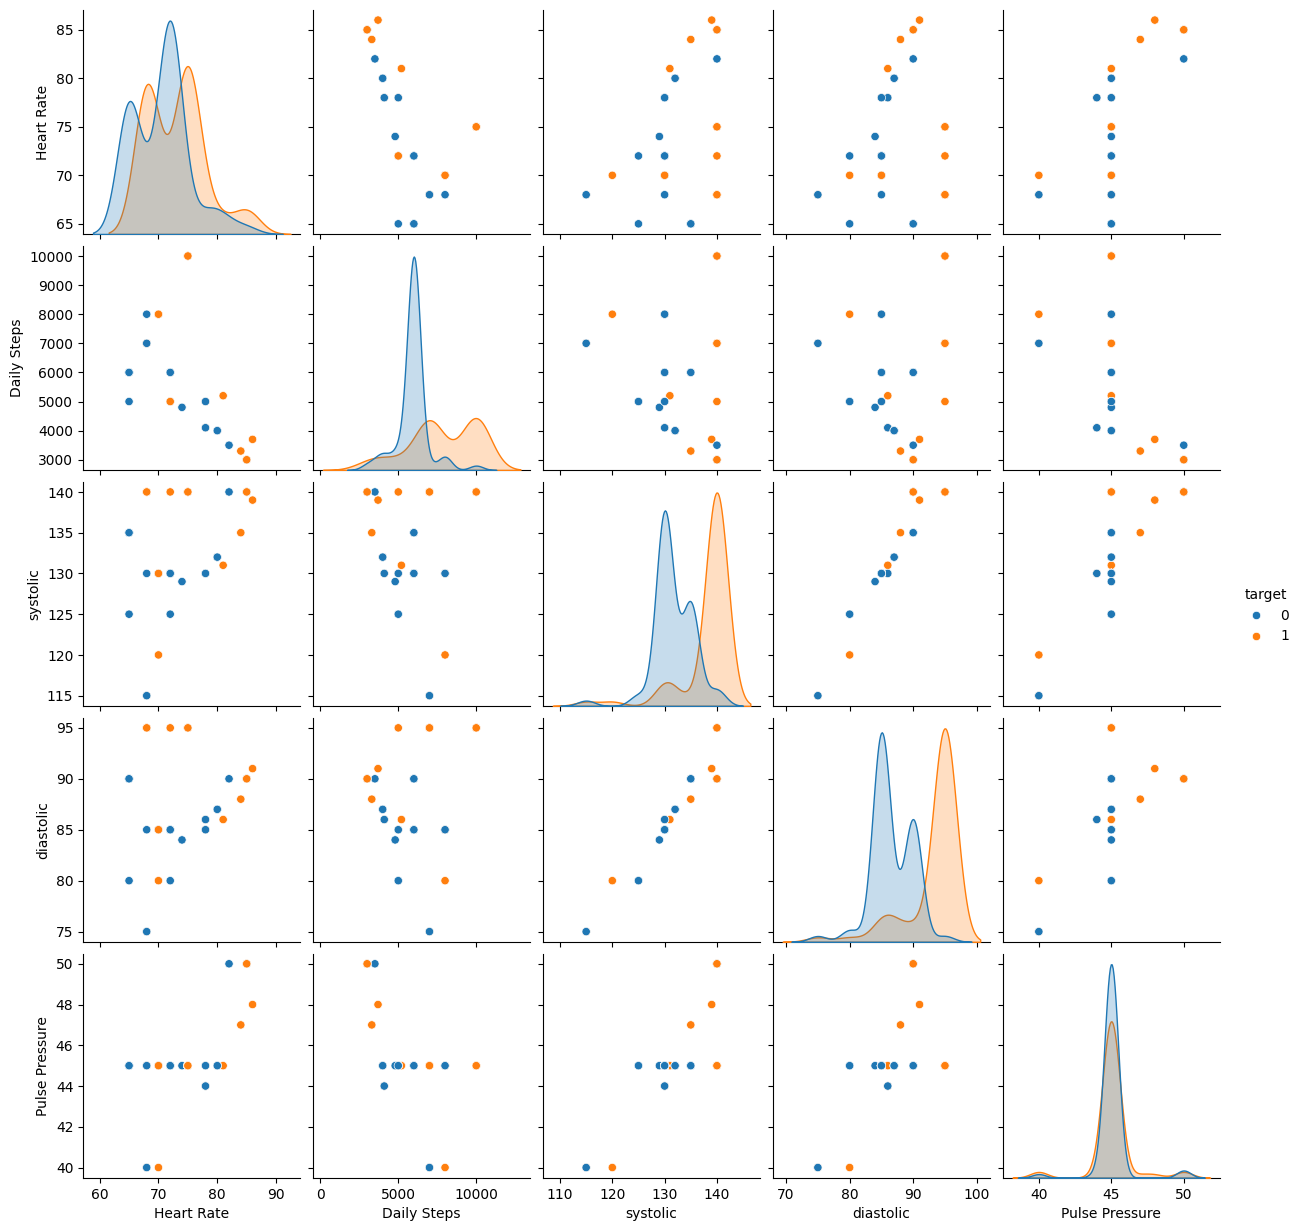

In [109]:
sns.pairplot(train_set_2[numericas[5:] + [targett]], hue= targett);

## Las features contra el target se diferencian bien, lo mismo que vimos en en análisis bivariante anterior

## Selección de features

Como anteriormente, he probado diferentes métodos para seleccionar las mejores features, incluyendo `mutual_info_classif`, `test de hipótesis`, `SelectFromModel`, `RFE`, `SFS`, `feature importance`, `Lasso`, `hard voting` y `selección manual`. Tras comparar el rendimiento de los modelos con cada enfoque, elegí estas variables con el `select from model` por ofrecer el mejor equilibrio entre precisión y utilidad.

In [110]:
todas = categoricas_int + numericas

In [111]:
# si nos fijamos manager sólo hay 1, estará en los datos de test, lo tenemos que quitar de aquí para que no de problemas
todas = [x for x in todas if x != 'Manager']

In [112]:
X_train_2 = train_set_2[todas]
y_train_2 = train_set_2['target']

In [113]:
# RFE
r_forest = RandomForestClassifier(random_state = 42)
rfe = RFE(estimator= r_forest)
rfe.fit(X_train_2, y_train_2)
rfe.transform(X_train_2)
RFE = rfe.get_feature_names_out().tolist()
RFE

['Gender_code',
 'Nurse',
 'Age',
 'Sleep Duration',
 'Quality of Sleep',
 'Physical Activity Level',
 'Stress Level',
 'Heart Rate',
 'Daily Steps',
 'systolic',
 'diastolic']

## Voy a hacer un test de hipótesis a estas features que son las que usaremos

In [114]:
lista_num = RFE + [targett]

In [115]:
for x in lista_num:
    grupo_a = train_set_2.loc[train_set_2.target == 0][x]
    grupo_b = train_set_2.loc[train_set_2.target == 1][x]
    u_stat, p_valor = mannwhitneyu(grupo_a, grupo_b)
    print('-',x,'-')
    print("Estadístico U:", u_stat)
    print("Valor p:", p_valor)

    if p_valor < 0.05:
        print('Hay diferencia estadísticamente significativa')
    else:
        print('No hay diferencia suficiente')
    print('------------------------------')

- Gender_code -
Estadístico U: 1105.0
Valor p: 5.5853804936747e-07
Hay diferencia estadísticamente significativa
------------------------------
- Nurse -
Estadístico U: 406.5
Valor p: 1.2080857610895516e-18
Hay diferencia estadísticamente significativa
------------------------------
- Age -
Estadístico U: 801.5
Valor p: 1.765514755853017e-08
Hay diferencia estadísticamente significativa
------------------------------
- Sleep Duration -
Estadístico U: 1988.5
Valor p: 0.7383392831626937
No hay diferencia suficiente
------------------------------
- Quality of Sleep -
Estadístico U: 1619.0
Valor p: 0.1086575540433775
No hay diferencia suficiente
------------------------------
- Physical Activity Level -
Estadístico U: 529.5
Valor p: 3.433644702748717e-13
Hay diferencia estadísticamente significativa
------------------------------
- Stress Level -
Estadístico U: 1757.5
Valor p: 0.39833502689469147
No hay diferencia suficiente
------------------------------
- Heart Rate -
Estadístico U: 1279

## Me voy a guardar estas variables, son las que no tienen significancia estadística

In [116]:
variables = ['Gender_code', 'Nurse', 'Age', 'Physical Activity Level', 'Heart Rate', 'Daily Steps', 'systolic', 'diastolic']

In [117]:
# mutual_info_classif

X2 = train_set_2[numericas]
y2 = train_set_2['target']

mic2 = mutual_info_classif(X2, y2)
print(pd.Series(mic, index=X2.columns).sort_values(ascending=False))

systolic                   0.358599
diastolic                  0.340943
Sleep Duration             0.315532
Daily Steps                0.271977
Age                        0.263672
Physical Activity Level    0.183018
Pulse Pressure             0.168918
Stress Level               0.153716
Quality of Sleep           0.106148
Heart Rate                 0.102002
dtype: float64


## Voy a visualizar con el target las últimas cuatro que son los que peores resultados tienen

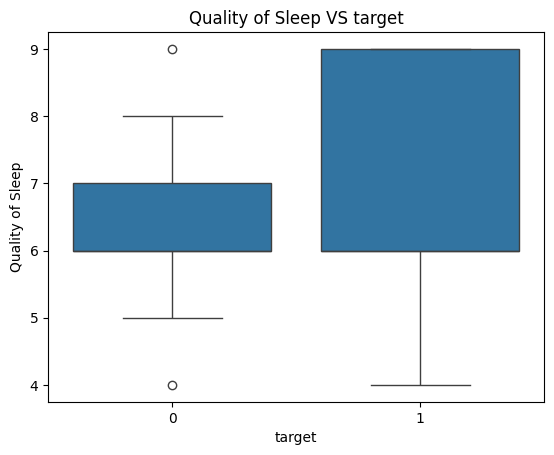

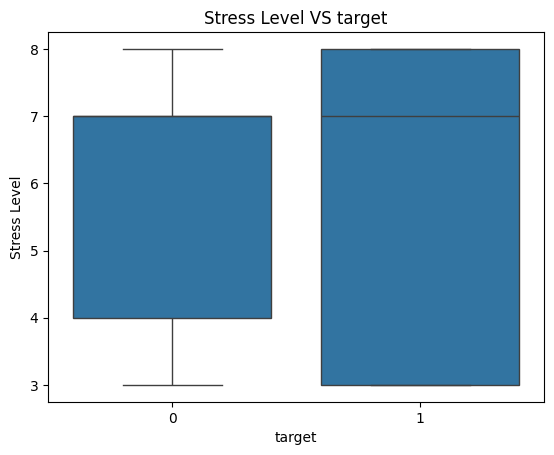

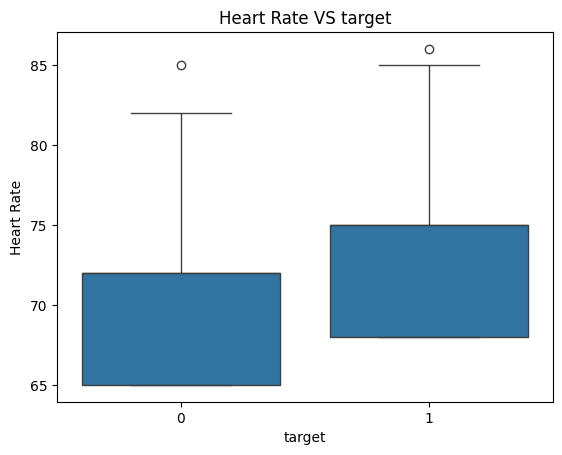

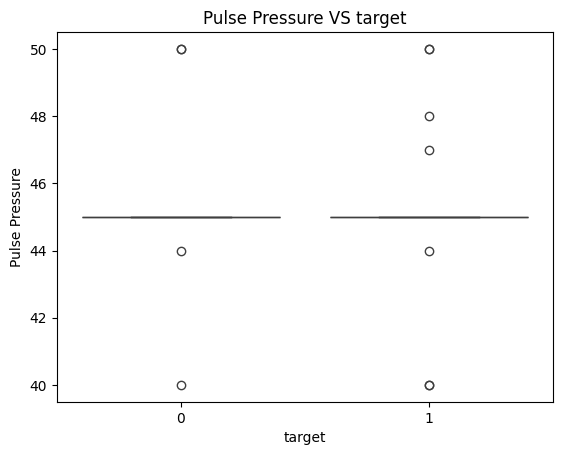

In [118]:
lista = ['Quality of Sleep', 'Stress Level', 'Heart Rate', 'Pulse Pressure']
for x in lista:
    plt.figure()
    sns.boxplot(data = train_set_2, x='target', y=x)
    plt.title(f'{x} VS target')

## La que peor se ve es la de 'Pulse Pressure', igualemnte probaremos con más métodos voy a hacer un test de Mann-Whitney U con estas cuatro features

In [119]:
for x in lista:
    grupo_a = train_set_2.loc[train_set_2.target == 0][x]
    grupo_b = train_set_2.loc[train_set_2.target == 1][x]
    u_stat, p_valor = mannwhitneyu(grupo_a, grupo_b)
    print('-',x,'-')
    print("Estadístico U:", u_stat)
    print("Valor p:", p_valor)

    if p_valor < 0.05:
        print('Hay diferencia estadísticamente significativa')
    else:
        print('No hay diferencia suficiente')
    print('------------------------------')

- Quality of Sleep -
Estadístico U: 1619.0
Valor p: 0.1086575540433775
No hay diferencia suficiente
------------------------------
- Stress Level -
Estadístico U: 1757.5
Valor p: 0.39833502689469147
No hay diferencia suficiente
------------------------------
- Heart Rate -
Estadístico U: 1279.0
Valor p: 0.0010467736900188459
Hay diferencia estadísticamente significativa
------------------------------
- Pulse Pressure -
Estadístico U: 1893.5
Valor p: 0.7804599599627191
No hay diferencia suficiente
------------------------------


## Voy a hacer una lista sin estas features que no tienen diferencia suficiente y dejamos la de heart rate que rechazamos la hipótesis nula y tenemos confianza de que si hay relación

In [120]:
numericas_test_u_stats = [x for x in numericas if x not in ['Quality of Sleep', 'Stress Level', 'Pulse Pressure']]
features_u_stat = categoricas_int + numericas_test_u_stats

## Tambien voy a probar otros métodos de selección de features

In [121]:
# SelectFromModel
r_forest = RandomForestClassifier(random_state = 42)

selector_model = SelectFromModel(estimator= r_forest, threshold='median')
selector_model.fit(X_train_2, y_train_2)
select_from_model_2 = selector_model.get_feature_names_out().tolist()

In [122]:
# SFS
sfs = SequentialFeatureSelector(r_forest, scoring = 'precision')
sfs.fit(X_train_2, y_train_2)
SFS_2 = sfs.get_feature_names_out().tolist()

In [123]:
# hard-voting

features_hard_voting_2 = select_from_model_2 + RFE + SFS_2
votos_2 = Counter(features_hard_voting_2)
seleccion_2 = [x for x,y in votos_2.most_common(10)]

In [124]:
# Feature importance

r_forest.fit(X_train_2, y_train_2)

importances_2 = r_forest.feature_importances_
feature_names_2 = X_train_2.columns

features_importance_2 = pd.Series(importances_2, index=X_train_2.columns).sort_values(ascending=False)

## Filtramos para quitar ruido

In [125]:
feature_importance_2 = [x for x,y in features_importance_2.items() if y >= 0.01]

## Voy a preparar todo para probar con diferentes features y diferentes modelos con validación cruzada

## Comparación de Modelos

Como anteriormente, con un bucle probé diferentes modelo (baseline):

* `RandomForestClassifier`
* `XGBClassifier`
* `LGBMClassifier`
* `GradientBoostingClassifier`
* `CatBoostClassifier`
* `DecisionTreeClassifier`
* `LogisticRegression`
* `KNeighborsClassifier`
* `SVC`

Todos fueron evaluados mediante **validación cruzada** con el scoring:
**`precision`**.

Comparé los resultados entre ellos mismos, seleccioné los modelos con mejor rendimiento e hice pruebas, ajusté hiperparámetros a cada modelo. La elección final del mejor modelo fue en base a obtener:

* **`classification_report`**
* **Importancia de variables (`feature_importances_`)**
* **`ConfusionMatrixDisplay`**

Viendo esto, me pude asegurar que lo que estaba eligiendo estaba funcionando bien para el problema a solucionar.

## Quito 'Manager' por el problema que vimos al inicio

In [126]:
features_u_stat = [x for x in features_u_stat if x != 'Manager']

In [127]:
dict_features = {
    'todas': todas,
    'u_stat': features_u_stat,
    'SFM' : select_from_model_2,
    'RFE' : RFE,
    'SFS' : SFS_2,
    'hard voting':seleccion_2,
    'feature import':feature_importance_2
}

## En esta ocasión no voy a usar categoricas de tipo 'category' para 'cat boost' y 'light gbm'

In [128]:
#Instanciamos los modelos
rforest = RandomForestClassifier(random_state= 42)
xgb = XGBClassifier(verbosity = 0, random_state= 42)
lgb = LGBMClassifier(verbose = -1, random_state= 42)
gradient = GradientBoostingClassifier(random_state= 42)
cat= CatBoostClassifier(verbose = False, random_state= 42)
tree = DecisionTreeClassifier(random_state= 42)
linear = LogisticRegression()
knn = KNeighborsClassifier()
svc = SVC()

#instanciamos el escalador para los modelos sensibles a la escala
scaler = StandardScaler()

# creamos un diccionario con todos los modelos
modelos = {
    'random forest' : rforest,
    'xgboost' : xgb,
    'light gbm' : lgb,
    'gradient' : gradient,
    'cat':cat,
    'tree':tree,
    'linear':linear,
    'knn': knn,
    'svc': svc
}


# vamos a hacer un bucle que depende del modelo se harán unas cosas u otras y todo se guarda en un diccionario para visualizarlo en un dataframe
resultados_2 = []
for nombre, modelo in modelos.items():
    if nombre in ['linear','knn', 'svc']:
        for clave, valor in dict_features.items():
            X_train_escalado = scaler.fit_transform(X_train_2[valor])
            cross = cross_validate(modelo, X_train_escalado, y_train_2, cv = 5 , scoring = ['precision'])
            resultados_2.append({
                'modelo': nombre,
                'metodo seleccion features' : clave,
                'precision' : np.mean(cross['test_precision'])
            })           
    else:
        for clave, valor in dict_features.items():
            cross = cross_validate(modelo, train_set_2[valor], y_train_2, cv = 5 , scoring = ['precision'])
            resultados_2.append({
                'modelo': nombre,
                'metodo seleccion features' : clave,
                'precision' : np.mean(cross['test_precision'])
            }) 

In [129]:
resultados_baseline_2 = pd.DataFrame(resultados_2).sort_values(by='precision', ascending=False)

In [130]:
pd.set_option('display.max_rows', None)

In [131]:
resultados_baseline_2

,modelo,metodo seleccion features,precision
11,xgboost,SFS,0.949231
18,light gbm,SFS,0.949231
53,knn,SFS,0.949231
25,gradient,SFS,0.935897
46,linear,SFS,0.935897
32,cat,SFS,0.935897
4,random forest,SFS,0.935897
39,tree,SFS,0.935897
60,svc,SFS,0.935897
49,knn,todas,0.932867


In [132]:
pd.reset_option('display.max_rows', None)

## Vamos a hacer validación cruzada para ver los resultados

## Para el modelo, usaremos las features que tienen diferencia estadísticamente significativa de RFE

In [133]:
variables = ['Gender_code', 'Nurse', 'Age', 'Physical Activity Level', 'Heart Rate', 'Daily Steps', 'systolic', 'diastolic']

In [134]:
#Instanciamos los modelos
xgb = XGBClassifier(verbosity = 0, random_state= 42)

In [135]:
cross = cross_validate(xgb, train_set_2[variables], y_train_2, cv = 5 , scoring = ['precision'])
print(f"precision {np.mean(cross['test_precision']):.4f}")

precision 0.8571


## El modelo XGB da buenos resultados para precision

In [136]:

## Aquí iria el proceso de pruebas con los mejores modelos y diferentes features, vamos directos al que funciona y he usado


## Al modelo le vamos a pasar unos hiperparámetros y un GridSearchCV

In [137]:
xgb2_ = XGBClassifier(eval_metric='logloss', random_state=42)
param_grid_xgb2_ = {
    'n_estimators': [100,200,300],
    'learning_rate': [0.1,0.2,0.3],
    'max_depth': [2,3,4, 5],
    'subsample': [0.7,0.8, 0.9],
    'colsample_bytree': [0.6,0.7,0.8, 1]
}

grid_xgb2_ = GridSearchCV(xgb2_, param_grid_xgb2_, cv=5, scoring='precision', n_jobs=-1, verbose=1)
grid_xgb2_.fit(train_set_2[variables], y_train_2)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8, 1],
                         'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [2, 3, 4, 5],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.7, 0.8, 0.9]},
             scoring='precision', verbose=1)

In [138]:
y_pred2_2 = grid_xgb2_.best_estimator_.predict(test_set_2[variables])
print(classification_report(y_test_2, y_pred2_2))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86        14
           1       0.88      0.88      0.88        17

    accuracy                           0.87        31
   macro avg       0.87      0.87      0.87        31
weighted avg       0.87      0.87      0.87        31



In [139]:
mejores_parametros_xgb = grid_xgb2_.best_params_

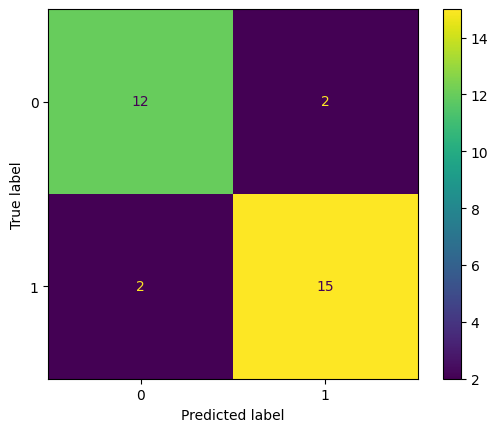

In [140]:
ConfusionMatrixDisplay.from_predictions(y_test_2, y_pred2_2);

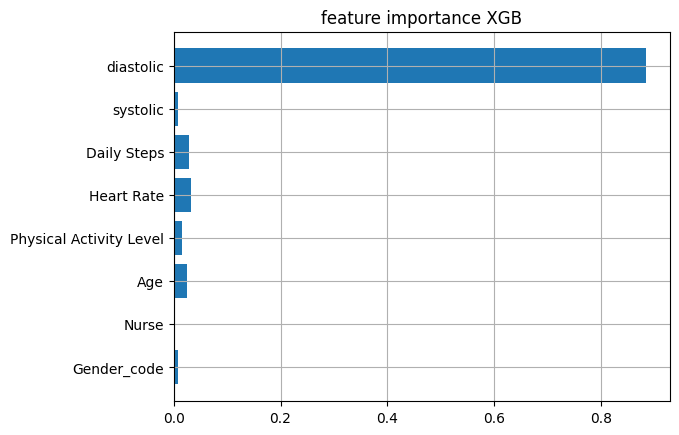

In [141]:
xgb2_.fit(train_set_2[variables], y_train_2)
plt.barh(train_set_2[variables].columns,xgb2_.feature_importances_)
plt.title('feature importance XGB')
plt.grid(True);

## Si que la columna 'diastolic' es muy dominante, eso es que esa columna es muy predictora, cuando quité estas columnas, el modelo dió unos resultados un poquito por debajo, pero resultados muy buenos también, como el modelo pasa por validacion cruzada cuando hacemos el gridSearch, nos indica que no hace overfiting porque los resultados se ven estables, tiene sentido desde un punto clínico porque la presión arterial va relacionada con la apnea del sueño

# Ahora voy a hacer un Pipeline para la transformación de datos para la producción y guardar el modelo y el pipeline, necesito cargar los datos y hacer las mismas transformaciones

In [142]:
data = pd.read_csv('./src/data/Sleep_Health_and_Lifestyle.csv')

In [143]:
data.drop(columns = ['Person ID', 'BMI Category'], inplace = True)
data.dropna(inplace=True)
data.rename(columns = {'Sleep Disorder':'target'}, inplace = True)
data['target'] = data['target'].map({'Insomnia':0, 'Sleep Apnea':1})
data[['systolic','diastolic']] = data['Blood Pressure'].str.extract(r'(\d+)/(\d+)', expand=True)
data.drop(columns='Blood Pressure', inplace=True)
data['systolic'] = data['systolic'].astype(int)
data['diastolic'] = data['diastolic'].astype(int)
data['Gender_code'] = data['Gender'].apply(lambda x: 0 if x == 'Male' else 1)
dummies_train_2 = pd.get_dummies(data['Occupation']).astype(int)
data = pd.concat([data, dummies_train_2], axis = 1)

## Después de hacer las transformaciones como anteriormente, vamos a construir unas funciones para pipeline

In [144]:
def gender_func(X):
    X = X.copy()
    X['Gender_code'] = (X == 'Femenino').astype(int)
    return X[['Gender_code']]

## Vamos a hacer el pipeline

In [145]:
gender = FunctionTransformer(gender_func)
nurse = FunctionTransformer(nurse_func)

# metemos todo en el columntransformer para que se hagan los cambios
preprocessor_2 = ColumnTransformer(
    transformers=[
        ('gender', gender, ['Gender']),
        ('nurse', nurse, ['Nurse'])
    ],
    remainder='passthrough' 
)
# el remainder se pone en 'passthrough' para que no afecte al resto de columnas

# este es el pipeline con todo dentro
pipeline2 = Pipeline([
    ('preprocessor', preprocessor_2)
])

## Creo un dataset simulando la entrada de los datos del cliente para hacer el fit del pipeline

In [146]:
X_t_2 = data[variables]
y_t_2 = data['target']

In [147]:
pipe_2 = pd.DataFrame({
                'Gender': 'Masculino',
                'Nurse':'Sí',
                'Age':27,
                'Physical Activity Level': 42,
                'Heart Rate':77,
                'Daily Steps':4200,
                'systolic':126,
                'diastolic':83
}, index = X_t_2.index)

In [148]:
pipe_2 = pipe_2.iloc[[0]]

In [149]:
pipeline2.fit(pipe_2)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('gender',
                                                  FunctionTransformer(func=<function gender_func at 0x0000013DF39A6A70>),
                                                  ['Gender']),
                                                 ('nurse',
                                                  FunctionTransformer(func=<function nurse_func at 0x0000013DEDCDAB00>),
                                                  ['Nurse'])]))])

# Hacemos un fit del modelo XGB también para poder guardarlo, en este caso no lo pongo dentro del pipeline, irá fuera

In [150]:
model = XGBClassifier(eval_metric='logloss', random_state=42, **mejores_parametros_xgb)

In [151]:
model.fit(X_t_2, y_t_2)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

### Construcción del Pipeline

Durante la construcción del pipeline especialmente para la transformación de datos, realizé diferentes pruebas y ajustes para asegurarme el buen funcionamiento en cada proceso para conseguir un flujo perfecto y robusto.

## Guardamos el modelo y el pipeline con joblib

In [155]:
joblib.dump(model, './src/models/modelo_entrenado_2_XGB.joblib')

['./src/models/modelo_entrenado_2_XGB.joblib']

In [153]:
joblib.dump(pipeline2, './src/models/pipeline_transformacion_2_XGB.joblib')

['./src/models/pipeline_transformacion_2_XGB.joblib']

# 🔗 ¡Prueba la aplicación!

Puedes probar el model y hacer un test sobre tú **calidad del sueño**, pedir información desde dónde hacer un estudio del sueño, una clínica para trabajar en un mejor sueño y enviartelo por mail para tener un acceso rápido en la app desarrollada con Streamlit. Solo tienes que introducir tus datos y obtendrás la predicción personalizada, además de recomendaciones útiles.

👉 [Haz clic aquí para acceder a la aplicación](https://health-and-sleep-relation.streamlit.app/)

